Placeholder Exec Sum.


## Library Installation

In [1]:
# Install the required libraries
#!pip install prophet
#!pip install mplfinance

## Importing Libraries

In [2]:

import pandas as pd
import datetime as dt
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import seaborn as sns
import numpy as np
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from datetime import timedelta
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.impute import SimpleImputer
import plotly.figure_factory as ff
import plotly.express as px
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LinearSegmentedColormap

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [3]:
# Global variables
DEFAULT_SYMBOL = 'TSLA'
IPO_DATE = '2010-06-29'  # Tesla's IPO date
start_date = IPO_DATE  # Default to IPO date, can be updated based on user input

def fetch_stock_data(ticker_symbol):
    """
    Fetches stock data for the given ticker symbol from the start date to the current date.
    The start date is a global variable that can be set based on user input or defaults to Tesla's IPO date.

    Parameters:
        ticker_symbol (str): The stock ticker symbol for which data is to be fetched.

    Returns:
        DataFrame: A DataFrame containing the stock data fetched from Yahoo Finance.
    """
    return yf.download(ticker_symbol, start=start_date)

# Prompt user for start date, defaulting to Tesla's IPO date if no input is provided
user_start_date = input(f"Enter the 4 digit year to start the analysis or press enter to default to Tesla's IPO year ({IPO_DATE[:4]}): ").strip()
if user_start_date:
    start_date = f"{user_start_date}-01-01"  # Assuming the start date is the first of the input year

# Fetch Tesla stock data as the primary stock for comparison
# Fetch Tesla stock data as the primary stock for comparison
stock_1_df = fetch_stock_data(DEFAULT_SYMBOL)

# Exclude weekends from stock_1_df
stock_1_df['Date'] = pd.to_datetime(stock_1_df.index)  # Ensure 'Date' column is datetime
stock_1_df = stock_1_df[stock_1_df['Date'].dt.dayofweek < 5]  # Filter out weekends

# Prompt for the first comparison stock symbol
symbol_2 = input("Enter the first ticker symbol you would like to compare with Tesla: ").strip().upper()

# Fetch data for the first comparison stock
stock_2_df = fetch_stock_data(symbol_2)

# Exclude weekends from stock_2_df
stock_2_df['Date'] = pd.to_datetime(stock_2_df.index)  # Ensure 'Date' column is datetime
stock_2_df = stock_2_df[stock_2_df['Date'].dt.dayofweek < 5]  # Filter out weekends

# Additional logic for further analysis and comparison can be added here

def fetch_market_index(index_symbol, start_date):
    """
    Fetches market index data from Yahoo Finance.

    Parameters:
        index_symbol (str): The market index symbol (e.g., '^GSPC' for S&P 500).
        start_date (str): The start date for fetching the data.

    Returns:
        DataFrame: A DataFrame containing the market index data.
    """
    return yf.download(index_symbol, start=start_date)

# Fetch market index data (e.g., S&P 500)
market_index_df = fetch_market_index('^GSPC', start_date)
market_index_series = market_index_df['Adj Close'].rename('market_index')
stock_1_df = stock_1_df.merge(market_index_series, left_index=True, right_index=True, how='left')
stock_1_df



Enter the 4 digit year to start the analysis or press enter to default to Tesla's IPO year (2010): 


[*********************100%%**********************]  1 of 1 completed


Enter the first ticker symbol you would like to compare with Tesla: HD


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
Date                                                                     
2010-06-29    1.266667    1.666667    1.169333    1.592667    1.592667   
2010-06-30    1.719333    2.028000    1.553333    1.588667    1.588667   
2010-07-01    1.666667    1.728000    1.351333    1.464000    1.464000   
2010-07-02    1.533333    1.540000    1.247333    1.280000    1.280000   
2010-07-06    1.333333    1.333333    1.055333    1.074000    1.074000   
...                ...         ...         ...         ...         ...   
2024-02-22  194.000000  198.320007  191.360001  197.410004  197.410004   
2024-02-23  195.309998  197.570007  191.500000  191.970001  191.970001   
2024-02-26  192.289993  201.779999  192.000000  199.399994  199.399994   
2024-02-27  204.039993  205.600006  198.259995  199.729996  199.729996   
2024-02-28  200.419998  205.300003  198.460007  202.039993  202.039993   

               Volume       Date  market_index  
Date                                            
2010-06-29  281494500 2010-06-29   1041.239990  
2010-06-30  257806500 2010-06-30   1030.709961  
2010-07-01  123282000 2010-07-01   1027.369995  
2010-07-02   77097000 2010-07-02   1022.580017  
2010-07-06  103003500 2010-07-06   1028.060059  
...               ...        ...           ...  
2024-02-22   92739500 2024-02-22   5087.029785  
2024-02-23   78670300 2024-02-23   5088.799805  
2024-02-26  111747100 2024-02-26   5069.529785  
2024-02-27  108645400 2024-02-27   5078.180176  
2024-02-28   98769230 2024-02-28   5069.759766  

[3440 rows x 8 columns]

In [4]:
print(start_date)

2010-06-29


In [5]:
stock_1_df_copy = stock_1_df
stock_2_df_copy = stock_2_df

### Dataframe Creation

In [6]:
stock_1_df


Open        High         Low       Close   Adj Close  \
Date                                                                     
2010-06-29    1.266667    1.666667    1.169333    1.592667    1.592667   
2010-06-30    1.719333    2.028000    1.553333    1.588667    1.588667   
2010-07-01    1.666667    1.728000    1.351333    1.464000    1.464000   
2010-07-02    1.533333    1.540000    1.247333    1.280000    1.280000   
2010-07-06    1.333333    1.333333    1.055333    1.074000    1.074000   
...                ...         ...         ...         ...         ...   
2024-02-22  194.000000  198.320007  191.360001  197.410004  197.410004   
2024-02-23  195.309998  197.570007  191.500000  191.970001  191.970001   
2024-02-26  192.289993  201.779999  192.000000  199.399994  199.399994   
2024-02-27  204.039993  205.600006  198.259995  199.729996  199.729996   
2024-02-28  200.419998  205.300003  198.460007  202.039993  202.039993   

               Volume       Date  market_index  
Date                                            
2010-06-29  281494500 2010-06-29   1041.239990  
2010-06-30  257806500 2010-06-30   1030.709961  
2010-07-01  123282000 2010-07-01   1027.369995  
2010-07-02   77097000 2010-07-02   1022.580017  
2010-07-06  103003500 2010-07-06   1028.060059  
...               ...        ...           ...  
2024-02-22   92739500 2024-02-22   5087.029785  
2024-02-23   78670300 2024-02-23   5088.799805  
2024-02-26  111747100 2024-02-26   5069.529785  
2024-02-27  108645400 2024-02-27   5078.180176  
2024-02-28   98769230 2024-02-28   5069.759766  

[3440 rows x 8 columns]

In [7]:
stock_2_df

Open        High         Low       Close   Adj Close  \
Date                                                                     
2010-06-29   29.150000   29.150000   28.420000   28.629999   20.820194   
2010-06-30   28.530001   28.860001   27.990000   28.070000   20.412949   
2010-07-01   28.410000   28.500000   27.490000   27.920000   20.303867   
2010-07-02   28.010000   28.010000   27.580000   27.760000   20.187513   
2010-07-06   27.990000   28.129999   27.100000   27.340000   19.882080   
...                ...         ...         ...         ...         ...   
2024-02-22  367.440002  372.959991  367.149994  371.339996  371.339996   
2024-02-23  372.079987  374.250000  370.250000  371.959991  371.959991   
2024-02-26  373.510010  374.880005  370.720001  371.600006  371.600006   
2024-02-27  372.660004  375.799988  370.609985  375.559998  375.559998   
2024-02-28  375.559998  379.839996  375.059998  377.609985  377.609985   

              Volume       Date  
Date                             
2010-06-29  22817400 2010-06-29  
2010-06-30  20940900 2010-06-30  
2010-07-01  27119600 2010-07-01  
2010-07-02  15404500 2010-07-02  
2010-07-06  18300200 2010-07-06  
...              ...        ...  
2024-02-22   3387500 2024-02-22  
2024-02-23   3398200 2024-02-23  
2024-02-26   2461000 2024-02-26  
2024-02-27   2802900 2024-02-27  
2024-02-28   2261701 2024-02-28  

[3440 rows x 7 columns]

## Initial Plots for Validation

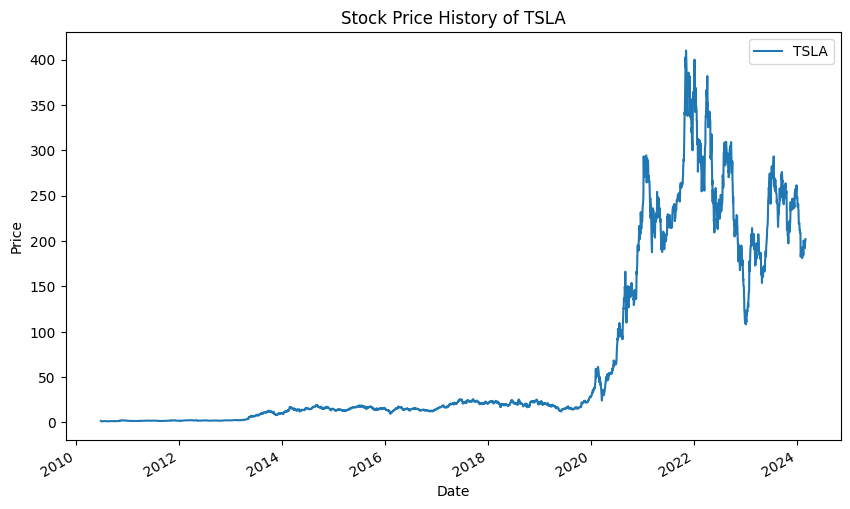

In [8]:
# Plot the data
stock_1_df['Adj Close'].plot(title=f'Stock Price History of {DEFAULT_SYMBOL.upper()}', figsize=(10, 6))

# Add labels to the x-axis and y-axis
plt.xlabel('Date')
plt.ylabel('Price')

# Add a legend
plt.legend([DEFAULT_SYMBOL.upper()])


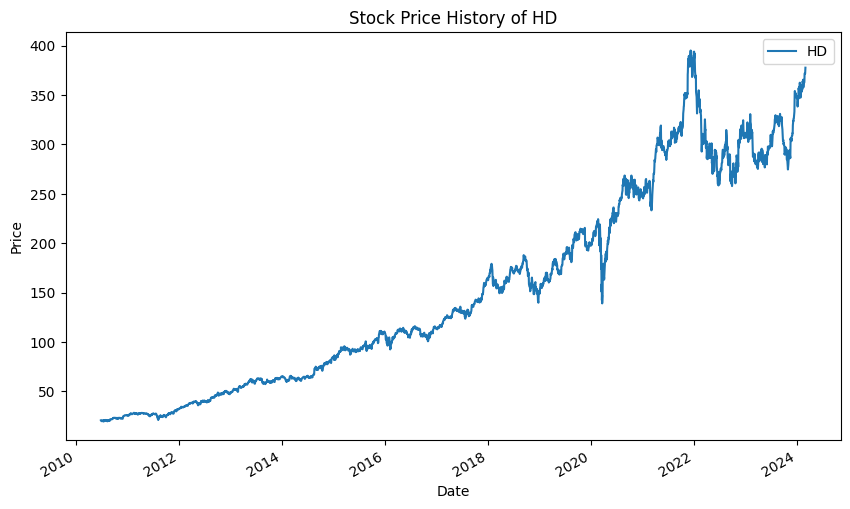

In [9]:
# Plot the data
stock_2_df['Adj Close'].plot(title=f'Stock Price History of {symbol_2.upper()}', figsize=(10, 6))

# Add labels to the x-axis and y-axis
plt.xlabel('Date')
plt.ylabel('Price')

# Add a legend
plt.legend([symbol_2.upper()])

# Display the plot
plt.show()

### Assignment of Calendar Days

In [10]:
stock_1_df['day_of_week'] = stock_1_df.index.day_name()
stock_1_df['month'] = stock_1_df.index.month_name()
stock_1_df['year'] = stock_1_df.index.year
stock_1_df.head()

Open      High       Low     Close  Adj Close     Volume  \
Date                                                                       
2010-06-29  1.266667  1.666667  1.169333  1.592667   1.592667  281494500   
2010-06-30  1.719333  2.028000  1.553333  1.588667   1.588667  257806500   
2010-07-01  1.666667  1.728000  1.351333  1.464000   1.464000  123282000   
2010-07-02  1.533333  1.540000  1.247333  1.280000   1.280000   77097000   
2010-07-06  1.333333  1.333333  1.055333  1.074000   1.074000  103003500   

                 Date  market_index day_of_week month  year  
Date                                                         
2010-06-29 2010-06-29   1041.239990     Tuesday  June  2010  
2010-06-30 2010-06-30   1030.709961   Wednesday  June  2010  
2010-07-01 2010-07-01   1027.369995    Thursday  July  2010  
2010-07-02 2010-07-02   1022.580017      Friday  July  2010  
2010-07-06 2010-07-06   1028.060059     Tuesday  July  2010

#### Average Closing Value by Day of the Week

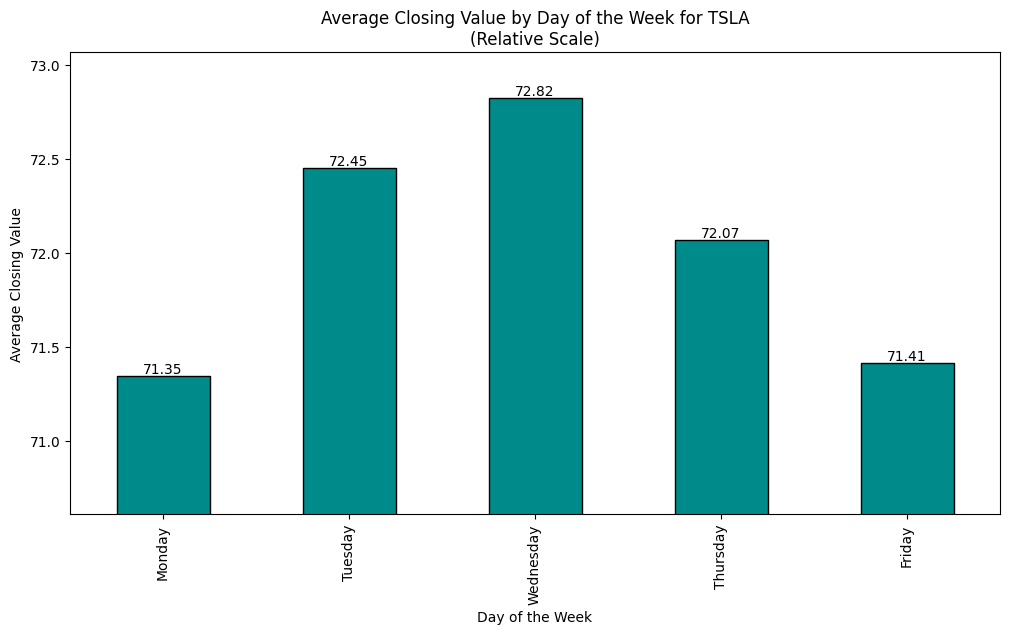

Open        High         Low       Close   Adj Close  \
Date                                                                     
2010-06-29    1.266667    1.666667    1.169333    1.592667    1.592667   
2010-06-30    1.719333    2.028000    1.553333    1.588667    1.588667   
2010-07-01    1.666667    1.728000    1.351333    1.464000    1.464000   
2010-07-02    1.533333    1.540000    1.247333    1.280000    1.280000   
2010-07-06    1.333333    1.333333    1.055333    1.074000    1.074000   
...                ...         ...         ...         ...         ...   
2024-02-22  194.000000  198.320007  191.360001  197.410004  197.410004   
2024-02-23  195.309998  197.570007  191.500000  191.970001  191.970001   
2024-02-26  192.289993  201.779999  192.000000  199.399994  199.399994   
2024-02-27  204.039993  205.600006  198.259995  199.729996  199.729996   
2024-02-28  200.419998  205.300003  198.460007  202.039993  202.039993   

               Volume       Date  market_index day_of_week     month  year  
Date                                                                        
2010-06-29  281494500 2010-06-29   1041.239990     Tuesday      June  2010  
2010-06-30  257806500 2010-06-30   1030.709961   Wednesday      June  2010  
2010-07-01  123282000 2010-07-01   1027.369995    Thursday      July  2010  
2010-07-02   77097000 2010-07-02   1022.580017      Friday      July  2010  
2010-07-06  103003500 2010-07-06   1028.060059     Tuesday      July  2010  
...               ...        ...           ...         ...       ...   ...  
2024-02-22   92739500 2024-02-22   5087.029785    Thursday  February  2024  
2024-02-23   78670300 2024-02-23   5088.799805      Friday  February  2024  
2024-02-26  111747100 2024-02-26   5069.529785      Monday  February  2024  
2024-02-27  108645400 2024-02-27   5078.180176     Tuesday  February  2024  
2024-02-28   98769230 2024-02-28   5069.759766   Wednesday  February  2024  

[3440 rows x 11 columns]

In [11]:
# Sort and categorize 'day_of_week' to ensure correct ordering
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
stock_1_df['day_of_week'] = pd.Categorical(stock_1_df['day_of_week'], categories=days_order, ordered=True)

# Calculate the mean close value by day of the week
avg_values = stock_1_df.groupby('day_of_week')['Close'].mean()

# Create a bar chart
plt.figure(figsize=(12, 6))
avg_values.plot(kind='bar', color='darkcyan', edgecolor='black')

# Determine the range of your data and set y-axis limits with padding
data_range = avg_values.max() - avg_values.min()
padding = data_range * .5  # 10% padding on each side
plt.ylim([avg_values.min() - padding, avg_values.max() + padding / 3])

# Add titles and labels
plt.title(f'Average Closing Value by Day of the Week for {DEFAULT_SYMBOL.upper()}\n(Relative Scale)')
plt.xlabel('Day of the Week')
plt.ylabel('Average Closing Value')

# Add data labels on top of each bar
for index, value in enumerate(avg_values):
    plt.text(index, value, f"{value:.2f}", ha='center', va='bottom')

plt.show()
stock_1_df




#### Average Closing Value by Month

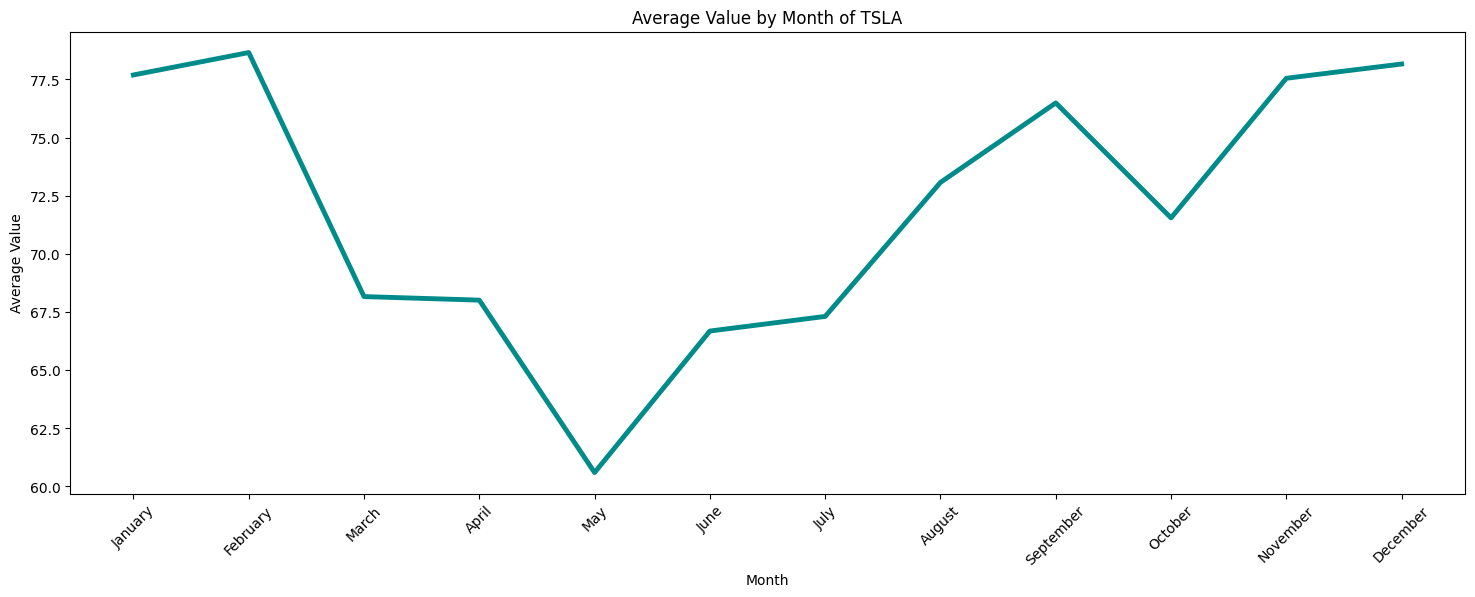

Open        High         Low       Close   Adj Close  \
Date                                                                     
2010-06-29    1.266667    1.666667    1.169333    1.592667    1.592667   
2010-06-30    1.719333    2.028000    1.553333    1.588667    1.588667   
2010-07-01    1.666667    1.728000    1.351333    1.464000    1.464000   
2010-07-02    1.533333    1.540000    1.247333    1.280000    1.280000   
2010-07-06    1.333333    1.333333    1.055333    1.074000    1.074000   
...                ...         ...         ...         ...         ...   
2024-02-22  194.000000  198.320007  191.360001  197.410004  197.410004   
2024-02-23  195.309998  197.570007  191.500000  191.970001  191.970001   
2024-02-26  192.289993  201.779999  192.000000  199.399994  199.399994   
2024-02-27  204.039993  205.600006  198.259995  199.729996  199.729996   
2024-02-28  200.419998  205.300003  198.460007  202.039993  202.039993   

               Volume       Date  market_index day_of_week     month  year  
Date                                                                        
2010-06-29  281494500 2010-06-29   1041.239990     Tuesday      June  2010  
2010-06-30  257806500 2010-06-30   1030.709961   Wednesday      June  2010  
2010-07-01  123282000 2010-07-01   1027.369995    Thursday      July  2010  
2010-07-02   77097000 2010-07-02   1022.580017      Friday      July  2010  
2010-07-06  103003500 2010-07-06   1028.060059     Tuesday      July  2010  
...               ...        ...           ...         ...       ...   ...  
2024-02-22   92739500 2024-02-22   5087.029785    Thursday  February  2024  
2024-02-23   78670300 2024-02-23   5088.799805      Friday  February  2024  
2024-02-26  111747100 2024-02-26   5069.529785      Monday  February  2024  
2024-02-27  108645400 2024-02-27   5078.180176     Tuesday  February  2024  
2024-02-28   98769230 2024-02-28   5069.759766   Wednesday  February  2024  

[3440 rows x 11 columns]

In [12]:
# Plotting trends by month
plt.figure(figsize=(18, 6))

# Explicitly specifying the order of months
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# First, ensure the 'month' column is categorical with the specified order
stock_1_df['month'] = pd.Categorical(stock_1_df['month'], categories=months_order, ordered=True)

# Then, group by 'month' and calculate the mean of 'Close', ensuring the result is indexed by the ordered 'month' categories
monthly_avg = stock_1_df.groupby('month')['Close'].mean().reindex(months_order)

# Plot the result
monthly_avg.plot(color="darkcyan", linewidth='3.5')

# Use `set_xticks` and `set_xticklabels` to ensure all months are displayed
plt.xticks(range(len(months_order)), months_order, rotation=45)

plt.title(f'Average Value by Month of {DEFAULT_SYMBOL.upper()}')
plt.xlabel('Month')
plt.ylabel('Average Value')
plt.show()
stock_1_df


### Stock 1 Moving Averages Plot

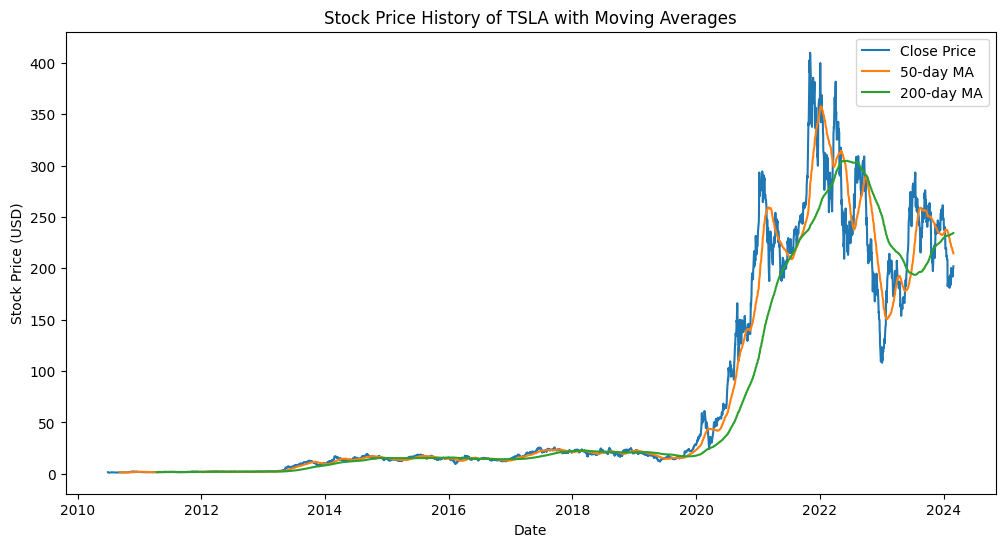

Open        High         Low       Close   Adj Close  \
Date                                                                     
2010-06-29    1.266667    1.666667    1.169333    1.592667    1.592667   
2010-06-30    1.719333    2.028000    1.553333    1.588667    1.588667   
2010-07-01    1.666667    1.728000    1.351333    1.464000    1.464000   
2010-07-02    1.533333    1.540000    1.247333    1.280000    1.280000   
2010-07-06    1.333333    1.333333    1.055333    1.074000    1.074000   
...                ...         ...         ...         ...         ...   
2024-02-22  194.000000  198.320007  191.360001  197.410004  197.410004   
2024-02-23  195.309998  197.570007  191.500000  191.970001  191.970001   
2024-02-26  192.289993  201.779999  192.000000  199.399994  199.399994   
2024-02-27  204.039993  205.600006  198.259995  199.729996  199.729996   
2024-02-28  200.419998  205.300003  198.460007  202.039993  202.039993   

               Volume       Date  market_index day_of_week     month  year  \
Date                                                                         
2010-06-29  281494500 2010-06-29   1041.239990     Tuesday      June  2010   
2010-06-30  257806500 2010-06-30   1030.709961   Wednesday      June  2010   
2010-07-01  123282000 2010-07-01   1027.369995    Thursday      July  2010   
2010-07-02   77097000 2010-07-02   1022.580017      Friday      July  2010   
2010-07-06  103003500 2010-07-06   1028.060059     Tuesday      July  2010   
...               ...        ...           ...         ...       ...   ...   
2024-02-22   92739500 2024-02-22   5087.029785    Thursday  February  2024   
2024-02-23   78670300 2024-02-23   5088.799805      Friday  February  2024   
2024-02-26  111747100 2024-02-26   5069.529785      Monday  February  2024   
2024-02-27  108645400 2024-02-27   5078.180176     Tuesday  February  2024   
2024-02-28   98769230 2024-02-28   5069.759766   Wednesday  February  2024   

                MA50      MA200  
Date                             
2010-06-29       NaN        NaN  
2010-06-30       NaN        NaN  
2010-07-01       NaN        NaN  
2010-07-02       NaN        NaN  
2010-07-06       NaN        NaN  
...              ...        ...  
2024-02-22  218.0672  233.88280  
2024-02-23  217.1118  233.98370  
2024-02-26  216.3596  234.13495  
2024-02-27  215.5684  234.29090  
2024-02-28  214.5882  234.44070  

[3440 rows x 13 columns]

In [13]:
# Get general idea of price against moving averages Above 200 day = good. Below = bad Above both = great
stock_1_df['MA50'] = stock_1_df['Adj Close'].rolling(window=50).mean()
stock_1_df['MA200'] = stock_1_df['Adj Close'].rolling(window=200).mean()

# Plotting moving averages
plt.figure(figsize=(12, 6))
plt.plot(stock_1_df['Adj Close'], label='Close Price')
plt.plot(stock_1_df['MA50'], label='50-day MA')
plt.plot(stock_1_df['MA200'], label='200-day MA')
plt.title(f'Stock Price History of {DEFAULT_SYMBOL.upper()} with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()
stock_1_df




## Data-split

In [14]:
# Assuming 'stock_1_df' is your DataFrame and you're predicting 'Adj Close'
X = stock_1_df.drop('Adj Close', axis=1)  # Features
y = stock_1_df['Adj Close']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 20% data as test set


In [15]:
stock_1_df

Open        High         Low       Close   Adj Close  \
Date                                                                     
2010-06-29    1.266667    1.666667    1.169333    1.592667    1.592667   
2010-06-30    1.719333    2.028000    1.553333    1.588667    1.588667   
2010-07-01    1.666667    1.728000    1.351333    1.464000    1.464000   
2010-07-02    1.533333    1.540000    1.247333    1.280000    1.280000   
2010-07-06    1.333333    1.333333    1.055333    1.074000    1.074000   
...                ...         ...         ...         ...         ...   
2024-02-22  194.000000  198.320007  191.360001  197.410004  197.410004   
2024-02-23  195.309998  197.570007  191.500000  191.970001  191.970001   
2024-02-26  192.289993  201.779999  192.000000  199.399994  199.399994   
2024-02-27  204.039993  205.600006  198.259995  199.729996  199.729996   
2024-02-28  200.419998  205.300003  198.460007  202.039993  202.039993   

               Volume       Date  market_index day_of_week     month  year  \
Date                                                                         
2010-06-29  281494500 2010-06-29   1041.239990     Tuesday      June  2010   
2010-06-30  257806500 2010-06-30   1030.709961   Wednesday      June  2010   
2010-07-01  123282000 2010-07-01   1027.369995    Thursday      July  2010   
2010-07-02   77097000 2010-07-02   1022.580017      Friday      July  2010   
2010-07-06  103003500 2010-07-06   1028.060059     Tuesday      July  2010   
...               ...        ...           ...         ...       ...   ...   
2024-02-22   92739500 2024-02-22   5087.029785    Thursday  February  2024   
2024-02-23   78670300 2024-02-23   5088.799805      Friday  February  2024   
2024-02-26  111747100 2024-02-26   5069.529785      Monday  February  2024   
2024-02-27  108645400 2024-02-27   5078.180176     Tuesday  February  2024   
2024-02-28   98769230 2024-02-28   5069.759766   Wednesday  February  2024   

                MA50      MA200  
Date                             
2010-06-29       NaN        NaN  
2010-06-30       NaN        NaN  
2010-07-01       NaN        NaN  
2010-07-02       NaN        NaN  
2010-07-06       NaN        NaN  
...              ...        ...  
2024-02-22  218.0672  233.88280  
2024-02-23  217.1118  233.98370  
2024-02-26  216.3596  234.13495  
2024-02-27  215.5684  234.29090  
2024-02-28  214.5882  234.44070  

[3440 rows x 13 columns]

# Machine Learning Module

Enter the number of days you want to forecast: 365


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/am3hk_si.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/o9pex3hv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85501', 'data', 'file=/tmp/tmpex2sxn0p/am3hk_si.json', 'init=/tmp/tmpex2sxn0p/o9pex3hv.json', 'output', 'file=/tmp/tmpex2sxn0p/prophet_modelcaxx51i0/prophet_model-20240229001524.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:15:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:15:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex

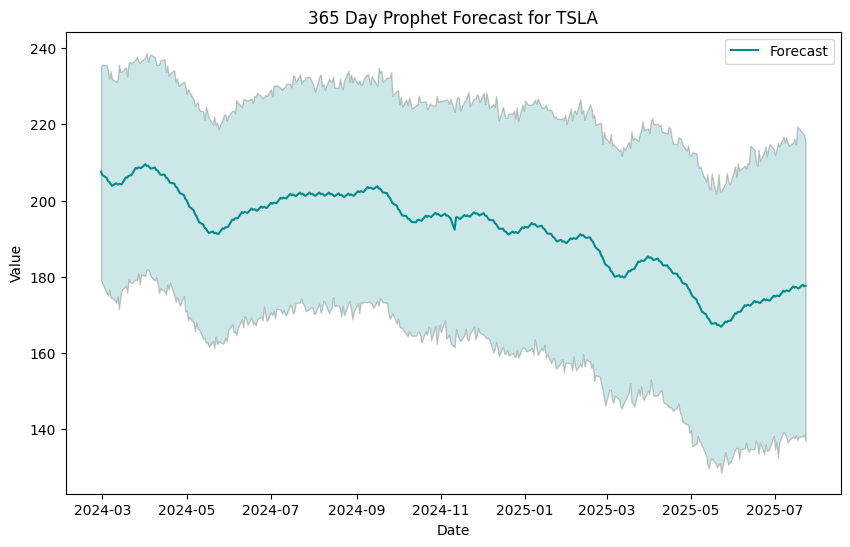

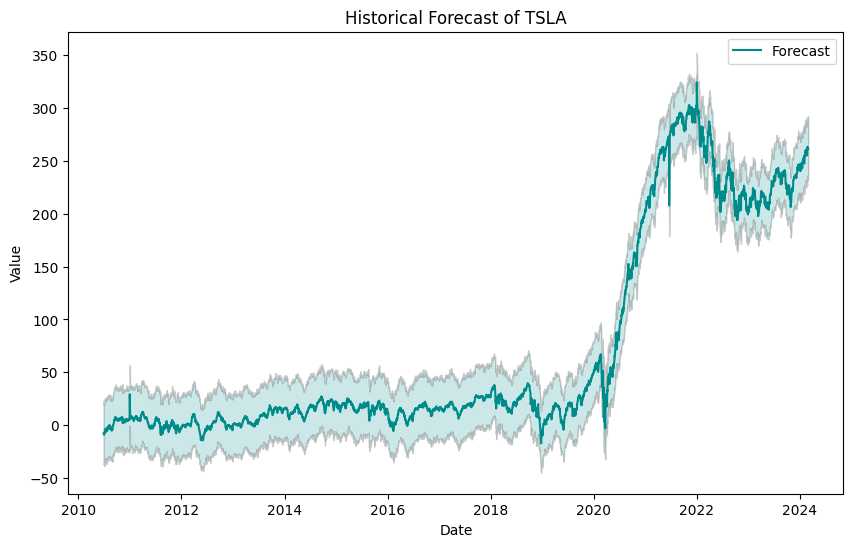

In [16]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Constants
WEEKDAYS = 5  # Represents Monday to Friday for filtering out weekends
SCALING_FACTOR = 2.0  # Used to scale the market index values

def preprocess_data(df):
    """
    Preprocess the stock data for forecasting.

    Parameters:
    - df: DataFrame containing stock data.

    Returns:
    - DataFrame with preprocessed stock data.
    """
    # Handle duplicate column names by appending a suffix
    df.columns = pd.Series(df.columns).apply(
        lambda x: x if df.columns.tolist().count(x) == 1 else f"{x}_{df.columns.tolist().index(x)}"
    )

    # Scale the market index by the predefined scaling factor
    df['market_index_scaled'] = df['market_index'] * SCALING_FACTOR

    # Fill NaN values in numeric columns with their respective column means
    numeric_cols = df.select_dtypes(include=['number']).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

    # Ensure there is a 'ds' datetime column for Prophet
    if 'Date' in df.columns:
        df['ds'] = pd.to_datetime(df['Date'])
    elif 'ds' not in df.columns:
        df.reset_index(inplace=True)
        df['ds'] = pd.to_datetime(df['index'])
    df.drop(columns=['Date', 'index'], errors='ignore', inplace=True)

    # Rename 'Adj Close' column to 'y' for Prophet compatibility
    if 'Adj Close' in df.columns:
        df.rename(columns={'Adj Close': 'y'}, inplace=True)

    # Filter out weekend data
    df = df[df['ds'].dt.weekday < WEEKDAYS]
    return df

def forecast_market_index(df, forecast_days):
    """
    Forecast the market index using Prophet.

    Parameters:
    - df: DataFrame with preprocessed stock data.
    - forecast_days: Number of days to forecast.

    Returns:
    - DataFrame with forecasted values for the specified number of days.
    """
    # Select and rename columns for Prophet model
    market_df = df[['ds', 'market_index_scaled']].rename(columns={'market_index_scaled': 'y'})

    # Initialize and fit the Prophet model
    model = Prophet()
    model.fit(market_df)

    # Create future dataframe for the forecast period
    future = model.make_future_dataframe(periods=forecast_days, freq='B')

    # Generate forecast
    forecast = model.predict(future)
    return forecast[['ds', 'yhat']].iloc[-forecast_days:]

def initialize_prophet_model_with_regressors():
    """
    Initialize a Prophet model with additional regressors and holidays.

    Returns:
    - Prophet model with configured settings.
    """
    model = Prophet()
    model.add_regressor('market_index_scaled')  # Add market index as a regressor
    model.add_country_holidays(country_name='US')  # Include US holidays
    return model

def fit_and_forecast(model, df, future_market_index_df, forecast_days):
    """
    Fit the Prophet model and forecast future values.

    Parameters:
    - model: Initialized Prophet model.
    - df: DataFrame with historical data for fitting.
    - future_market_index_df: DataFrame with future 'market_index_scaled' values for forecasting.
    - forecast_days: Number of days to forecast.

    Returns:
    - DataFrame with forecasted values.
    """
    model.fit(df)
    future_df = future_market_index_df[['ds', 'yhat']].rename(columns={'yhat': 'market_index_scaled'})
    forecast = model.predict(future_df)
    return forecast

def plot_forecast(forecast, title):
    """
    Plot the forecasted data.

    Parameters:
    - forecast: DataFrame containing forecasted values.
    - title: Title for the plot.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='darkcyan', linewidth='1.5')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='darkcyan', alpha=0.2, edgecolor='black')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

def main(stock_df, forecast_days, DEFAULT_SYMBOL='Your Default Symbol'):
    """
    Main function to orchestrate data preprocessing, model fitting, forecasting, and plotting.

    Parameters:
    - stock_df: DataFrame containing stock data.
    - forecast_days: Number of days to forecast.
    - DEFAULT_SYMBOL: Symbol for the stock being forecasted.

    Returns:
    - Dictionary containing 'future_forecast' and 'historical_forecast'.
    """
    # Preprocess the input stock data
    stock_df = preprocess_data(stock_df)

    # Forecast future market index values
    future_market_index_df = forecast_market_index(stock_df, forecast_days)

    # Initialize and configure the Prophet model with regressors and holidays
    prophet_model = initialize_prophet_model_with_regressors()

    # Fit the model and forecast future values
    forecast = fit_and_forecast(prophet_model, stock_df, future_market_index_df, forecast_days)

    # Plot the forecast results
    plot_forecast(forecast, f'{forecast_days} Day Prophet Forecast for {DEFAULT_SYMBOL}')

    # Optionally, forecast on historical data to evaluate model performance
    historical_forecast = prophet_model.predict(stock_df)
    plot_forecast(historical_forecast, f'Historical Forecast of {DEFAULT_SYMBOL}')

    # Return both the future and historical forecasts
    return {'future_forecast': forecast, 'historical_forecast': historical_forecast}

if __name__ == "__main__":
    # User inputs for the forecast days and default symbol
    forecast_days = int(input("Enter the number of days you want to forecast: "))
    DEFAULT_SYMBOL = 'TSLA'  # Example symbol, replace with the actual symbol as needed

    # Ensure the dataframe 'stock_1_df' is defined with the appropriate structure
    forecasts = main(stock_1_df, forecast_days, DEFAULT_SYMBOL)
    future_forecast = forecasts['future_forecast']
    historical_forecast = forecasts['historical_forecast']

    # Future and historical forecasts are now available for further analysis or visualization

In [17]:
historical_forecast

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0    2010-06-29  93.007844  -36.611936   23.018748    93.007844    93.007844   
1    2010-06-30  92.984470  -37.178495   18.502347    92.984470    92.984470   
2    2010-07-01  92.961096  -35.211920   21.429021    92.961096    92.961096   
3    2010-07-02  92.937722  -37.596699   19.244219    92.937722    92.937722   
4    2010-07-06  92.844225  -38.611930   20.762704    92.844225    92.844225   
...         ...        ...         ...         ...          ...          ...   
3435 2024-02-22  62.264778  235.557124  291.304845    62.264778    62.264778   
3436 2024-02-23  62.190087  233.314936  291.145376    62.190087    62.190087   
3437 2024-02-26  61.966013  232.626590  290.462945    61.966013    61.966013   
3438 2024-02-27  61.891321  231.860066  292.267622    61.891321    61.891321   
3439 2024-02-28  61.816630  232.070430  290.163802    61.816630    61.816630   

      Christmas Day  Christmas Day_lower  Christmas Day_upper  \
0               0.0                  0.0                  0.0   
1               0.0                  0.0                  0.0   
2               0.0                  0.0                  0.0   
3               0.0                  0.0                  0.0   
4               0.0                  0.0                  0.0   
...             ...                  ...                  ...   
3435            0.0                  0.0                  0.0   
3436            0.0                  0.0                  0.0   
3437            0.0                  0.0                  0.0   
3438            0.0                  0.0                  0.0   
3439            0.0                  0.0                  0.0   

      Christmas Day (observed)  ...     weekly  weekly_lower  weekly_upper  \
0                          0.0  ...  18.291746     18.291746     18.291746   
1                          0.0  ...  18.494461     18.494461     18.494461   
2                          0.0  ...  18.231325     18.231325     18.231325   
3                          0.0  ...  17.950223     17.950223     17.950223   
4                          0.0  ...  18.291746     18.291746     18.291746   
...                        ...  ...        ...           ...           ...   
3435                       0.0  ...  18.231325     18.231325     18.231325   
3436                       0.0  ...  17.950223     17.950223     17.950223   
3437                       0.0  ...  18.750880     18.750880     18.750880   
3438                       0.0  ...  18.291746     18.291746     18.291746   
3439                       0.0  ...  18.494461     18.494461     18.494461   

        yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0    -1.148246     -1.148246     -1.148246                   0.0   
1    -1.004090     -1.004090     -1.004090                   0.0   
2    -0.872639     -0.872639     -0.872639                   0.0   
3    -0.755034     -0.755034     -0.755034                   0.0   
4    -0.442490     -0.442490     -0.442490                   0.0   
...        ...           ...           ...                   ...   
3435 -2.512084     -2.512084     -2.512084                   0.0   
3436 -2.659130     -2.659130     -2.659130                   0.0   
3437 -3.080859     -3.080859     -3.080859                   0.0   
3438 -3.197417     -3.197417     -3.197417                   0.0   
3439 -3.293208     -3.293208     -3.293208                   0.0   

      multiplicative_terms_lower  multiplicative_terms_upper        yhat  
0                            0.0                         0.0   -7.569895  
1                            0.0                         0.0   -8.035370  
2                            0.0                         0.0   -8.440679  
3                            0.0                         0.0   -8.986443  
4                            0.0                         0.0   -8.015276  
...                          ...                         ...       

In [18]:
# Assuming X is your DataFrame

# Separate numeric and non-numeric columns
X_numeric = X.select_dtypes(include=['float64', 'int64'])
X_non_numeric = X.select_dtypes(exclude=['float64', 'int64'])

# Initialize and apply the SimpleImputer to numeric columns
imputer = SimpleImputer(strategy='mean')
X_numeric_imputed = imputer.fit_transform(X_numeric)

# Convert the imputed array back to a DataFrame with the original numeric column names
X_numeric_imputed = pd.DataFrame(X_numeric_imputed, columns=X_numeric.columns)

# Concatenate the imputed numeric data with the non-numeric data
X_imputed = pd.concat([X_numeric_imputed, X_non_numeric], axis=1)

# You might need to reorder the columns to match the original DataFrame's order
X_imputed = X_imputed[X.columns]

In [19]:
# Constants
SCALING_FACTOR = 2.0  # Represents the scaling factor for the market index

# Preprocess the data
def preprocess_data(df):
    if 'market_index' not in df.columns:
        raise ValueError("DataFrame must include 'market_index' column")
    df['ds'] = pd.to_datetime(df['ds'])
    df['y'] = df['Close']  # Assuming 'Close' is the target variable
    df['market_index_scaled'] = df['market_index'] * SCALING_FACTOR
    return df[['ds', 'y', 'market_index_scaled']]

# Function to forecast the market index for a specific date
def forecast_market_index_for_date(ds, model, history):
        # Convert 'ds' to datetime if it's not already
    ds_date = pd.to_datetime(ds)

    # Check if 'ds' is a weekend
    if ds_date.weekday() >= 5:  # 5 for Saturday, 6 for Sunday

        # If 'ds' is a weekend, find the next Monday (or the last Friday if predicting backwards)
        # Adjust this logic based on your forecasting direction (forward or backward)
        ds_date = ds_date + pd.Timedelta(days=(7 - ds_date.weekday()))  # Move to next Monday

    # Create a future DataFrame for a single date 'ds'
    future_df = pd.DataFrame({'ds': [ds]})

    # Check if the date 'ds' is within the historical data range
    if ds in history['ds'].values:
        # If 'ds' is in the historical data, use the corresponding 'market_index_scaled' value
        market_index_scaled_value = history[history['ds'] == ds]['market_index_scaled'].iloc[0]
    else:
        # If 'ds' is not in the historical data (i.e., a future date), forecast 'market_index_scaled'
        # This could be a simple forward fill, a separate model forecast, or another method
        # For simplicity, let's use the last available 'market_index_scaled' value from the historical data
        market_index_scaled_value = history['market_index_scaled'].iloc[-1]

    # Add the 'market_index_scaled' value to 'future_df'
    future_df['market_index_scaled'] = [market_index_scaled_value]

    # Predict using the Prophet model
    forecast = model.predict(future_df)

    return forecast.iloc[0]['yhat']

# Wrapper function to forecast the scaled market index as a regressor
def your_regressor_forecast_function(ds, model, history):
    if isinstance(ds, pd.Series):
        return ds.apply(lambda x: forecast_market_index_for_date(x, model, history) * SCALING_FACTOR)
    else:
        return forecast_market_index_for_date(ds, model, history) * SCALING_FACTOR

# Main function to preprocess data, fit model, and perform cross-validation
def main(stock_df):
    # Preprocess your data
    preprocessed_df = preprocess_data(stock_df)
    if 'market_index_scaled' not in preprocessed_df.columns:
        raise ValueError("'market_index_scaled' column is missing after preprocessing")

    # Initialize the Prophet model with the market index as a regressor
    prophet_market_model = Prophet()
    prophet_market_model.add_regressor('market_index_scaled')

    # Fit the model with preprocessed data
    prophet_market_model.fit(preprocessed_df)

    # Define cross-validation parameters
    horizon = '365 days'  # Forecast horizon
    initial = '700 days'  # Initial training period
    period = '100 days'  # Spacing between cutoff dates

    # Run cross-validation
    df_cv = cross_validation(prophet_market_model, initial=initial, period=period, horizon=horizon)

    # Before evaluating performance, ensure that the regressor values are forecasted and included for future dates
    df_cv['market_index_scaled'] = df_cv['ds'].apply(lambda x: your_regressor_forecast_function(x, prophet_market_model, preprocessed_df))

    # Evaluate performance
    df_p = performance_metrics(df_cv)

    # Review performance metrics
    print(df_p[['horizon', 'rmse', 'mae']])

    return df_p, df_cv

if __name__ == "__main__":
    # Load your DataFrame here, e.g., stock_1_df = pd.read_csv('path_to_your_data.csv')
    # Ensure 'stock_1_df' is your DataFrame containing historical stock data including the market index
    df_p, df_cv = main(stock_1_df)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/cah43s29.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/y4c5cpoc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80572', 'data', 'file=/tmp/tmpex2sxn0p/cah43s29.json', 'init=/tmp/tmpex2sxn0p/y4c5cpoc.json', 'output', 'file=/tmp/tmpex2sxn0p/prophet_modeluhrr1z7x/prophet_model-20240229001533.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:15:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:15:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 40 forecasts with cutoffs between 2012-06-25 00:00:00 and 2023-02-28 00:00:00


  0%|          | 0/40 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/hgbaf66f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/qof0lz14.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30665', 'data', 'file=/tmp/tmpex2sxn0p/hgbaf66f.json', 'init=/tmp/tmpex2sxn0p/qof0lz14.json', 'output', 'file=/tmp/tmpex2sxn0p/prophet_modelkmzr_evc/prophet_model-20240229001535.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:15:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:15:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/zedi0tf5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/4qi952tc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

     horizon       rmse        mae
0    37 days  37.429261  18.526793
1    38 days  37.929952  18.744999
2    39 days  38.371639  18.957341
3    40 days  38.878003  19.204470
4    41 days  39.014034  19.349908
..       ...        ...        ...
324 361 days  93.420005  52.618930
325 362 days  93.335402  52.649788
326 363 days  93.513796  52.860814
327 364 days  94.226643  53.266127
328 365 days  94.809217  53.667034

[329 rows x 3 columns]


In [20]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Create a figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=stock_1_df['ds'], y=stock_1_df['y'], name='Actual',
               line=dict(color='grey', width=3), mode='lines+markers',
               marker=dict(size=5)),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df_cv['ds'], y=df_cv['yhat'], name='Predicted',
               line=dict(color='darkcyan', width=2, dash='dash'), mode='lines+markers',
               marker=dict(size=3)),
    secondary_y=False,
)



fig.update_layout(
    title='Actual vs Predicted Values Over Time',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Value'),
    hovermode='closest',
    template='plotly_white'
)

fig.show()


In [21]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Assuming df_p is your DataFrame with 'horizon' as timedelta64[ns]
# and assuming a start date (replace with your actual start date)
start_date = pd.to_datetime('2023-01-01')

# Convert 'horizon' from timedelta to actual datetime for plotting
df_p['date'] = start_date + df_p['horizon']

# If you have multiple data points per 'horizon', aggregate them here
# For simplicity, I'm assuming one data point per horizon
# Create a secondary line for the count of data points, here assumed as 1 for simplicity
df_p['data_count'] = 1  # Adjust this based on your actual data structure

# Create the subplot with secondary Y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add the RMSE line plot
fig.add_trace(
    go.Scatter(x=df_p['date'], y=df_p['mae'], name='RMSE', mode='lines'),
    secondary_y=False,
)



# Update layout with dynamic x-axis labeling and titles
fig.update_layout(
    title='RMSE and Data Points Count Over Time',
    xaxis_title='Date',
    yaxis_title='Root Mean Square Error',
    xaxis=dict(
        tickformat='%Y-%m-%d',  # Format date
        tickmode='auto',
        nticks=20  # Adjust the number of ticks to avoid crowding, change as needed
    ),
    template='plotly_white',
    hovermode='closest'
)

# Set secondary Y-axis title
fig.update_yaxes(title_text='Data Points Count', secondary_y=True)

# Show the figure
fig.show()


In [22]:

# Calculate prediction errors
df_cv['error'] = df_cv['yhat'] - df_cv['y']

# Calculate mean and standard deviation of errors
mean_error = np.mean(df_cv['error'])
std_dev_error = np.std(df_cv['error'])

# Create histogram data for errors
hist_data = [df_cv['error']]
group_labels = ['Prediction Error']

# Create distplot with custom bin_size
bin_size = 0.5
fig = ff.create_distplot(hist_data, group_labels, bin_size=bin_size,
                         curve_type='normal',  # Overlay a normal distribution curve
                         colors=['darkcyan'])

# Add mean line
fig.add_trace(go.Scatter(x=[mean_error, mean_error], y=[0, max(fig.data[1].y)],
                         mode='lines', name='Mean',
                         line=dict(color='red', width=2, dash='dash')))

# Add standard deviation lines
fig.add_trace(go.Scatter(x=[mean_error - std_dev_error, mean_error - std_dev_error],
                         y=[0, max(fig.data[1].y)],
                         mode='lines', name='Mean - 1 SD',
                         line=dict(color='purple', width=2, dash='dot')))

fig.add_trace(go.Scatter(x=[mean_error + std_dev_error, mean_error + std_dev_error],
                         y=[0, max(fig.data[1].y)],
                         mode='lines', name='Mean + 1 SD',
                         line=dict(color='purple', width=2, dash='dot')))

# Customize layout for better readability and aesthetics
fig.update_layout(
    title='Distribution of Prediction Errors with Mean and Standard Deviation within ',
    xaxis=dict(title='Prediction Error'),
    yaxis=dict(title='Density'),
    template='plotly_white',
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)

# Enhance hover information
for trace in fig.data[-3:]:
    trace.hoverinfo = 'x+name'

fig.show()


In [23]:
fig = px.bar(df_p, x='horizon', y='mae', title='Mean Absolute Error by Forecast Horizon',
             labels={'mae': 'Mean Absolute Error', 'horizon': 'Forecast Horizon'})

# Custom colormap from white to yellow to orange to red
colors = ["white", "darkcyan"]
n_bins = 100  # Increase this number for a smoother transition
cmap = LinearSegmentedColormap.from_list(name="custom", colors=colors, N=n_bins)

fig.update_layout(template='plotly_white',
                  )
fig.show()


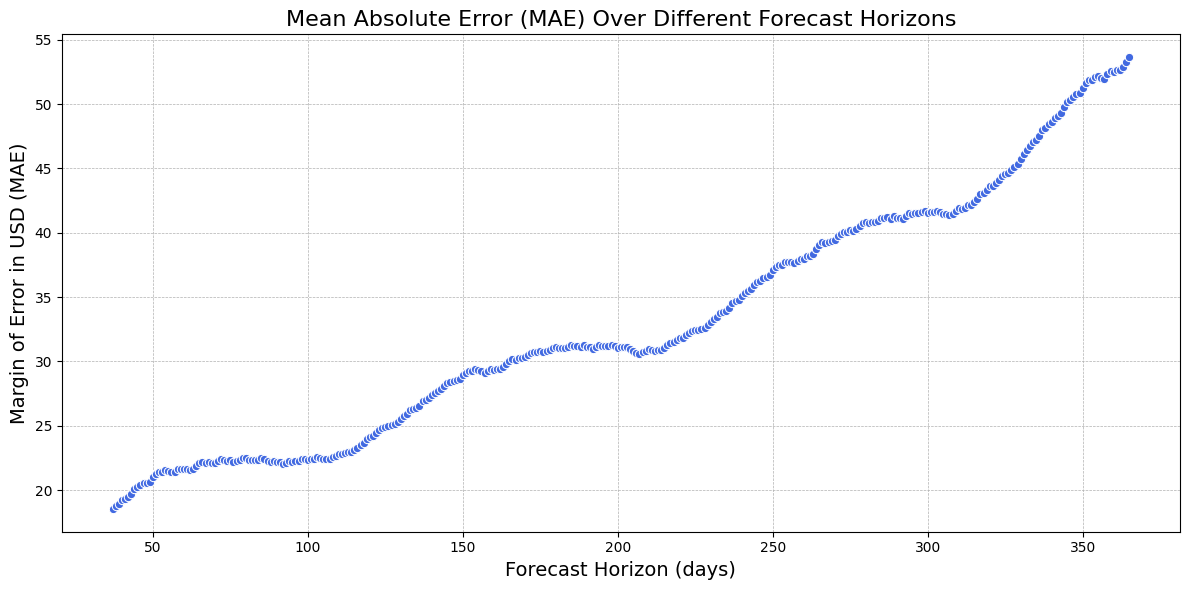

     horizon        mae  horizon_days
0    37 days  18.526793            37
1    38 days  18.744999            38
2    39 days  18.957341            39
3    40 days  19.204470            40
4    41 days  19.349908            41
..       ...        ...           ...
324 361 days  52.618930           361
325 362 days  52.649788           362
326 363 days  52.860814           363
327 364 days  53.266127           364
328 365 days  53.667034           365

[329 rows x 3 columns]


In [24]:
# Assuming df_p is the performance metrics DataFrame obtained from Prophet's performance_metrics function
mae_data = df_p[['horizon', 'mae']].copy()

plt.figure(figsize=(12, 6))

# Convert 'horizon' from days to a more readable format if necessary (e.g., number of days)
mae_data['horizon_days'] = mae_data['horizon'].dt.days

# Create the plot
sns.lineplot(x='horizon_days', y='mae', data=mae_data, marker='o', color='royalblue', linewidth=2.5)

# Enhance the plot
plt.title('Mean Absolute Error (MAE) Over Different Forecast Horizons', fontsize=16)
plt.xlabel('Forecast Horizon (days)', fontsize=14)
plt.ylabel('Margin of Error in USD (MAE)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
print(mae_data)

In [25]:
# # Rename 'ds' column to 'Date' and 'y' column to 'Adj Close'
# stock_1_df.rename(columns={'ds': 'Date', 'y': 'Adj Close'}, inplace=True)
# stock_1_df

In [26]:
# import matplotlib.dates as mdates
# from matplotlib.ticker import MaxNLocator
# import pandas as pd

# # Assuming 'forecast' now holds the historical forecast data equivalent to 'historical_forecast'
# # Ensure 'ds' is in the proper format if it's not already
# stock_1_df['ds'] = pd.to_datetime(stock_1_df['ds'])

# # Plot historical data
# plt.figure(figsize=(14, 8))
# plt.plot(stock_1_df['ds'], stock_1_df['y'], label='Historical', color='blue')  # Assuming 'y' is the historical closing value column

# # Plot forecast
# plt.plot(historical_forecast['ds'], historical_forecast['yhat'], label='Forecast', color='red', linestyle='--')

# # Highlight forecast period
# plt.axvline(x=stock_1_df['ds'].iloc[-1], color='gray', linestyle='--', label='Start of Forecast')

# # Optionally, plot components of the forecast, such as confidence intervals
#  plt.fill_between(future_forecast['ds'], future_forecast['yhat_lower'], future_forecast['yhat_upper'], color='red', alpha=0.2)

# # Formatting
# plt.title('Prophet Forecast with Market Index Regressor')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.legend()

# # Dynamic x-axis scaling
# date_range = stock_1_df['ds'].max() - stock_1_df['ds'].min()
# if date_range <= pd.Timedelta(days=180):
#     locator = mdates.MonthLocator()
# elif pd.Timedelta(days=180) < date_range <= pd.Timedelta(days=365):
#     locator = mdates.MonthLocator(bymonth=(1, 4, 7, 10))
# else:
#     locator = mdates.YearLocator()

# plt.gca().xaxis.set_major_locator(locator)
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# plt.gcf().autofmt_xdate()  # Rotation and alignment of x-axis labels

# plt.show()


In [27]:
stock_1_df

Open        High         Low       Close           y  \
Date                                                                     
2010-06-29    1.266667    1.666667    1.169333    1.592667    1.592667   
2010-06-30    1.719333    2.028000    1.553333    1.588667    1.588667   
2010-07-01    1.666667    1.728000    1.351333    1.464000    1.464000   
2010-07-02    1.533333    1.540000    1.247333    1.280000    1.280000   
2010-07-06    1.333333    1.333333    1.055333    1.074000    1.074000   
...                ...         ...         ...         ...         ...   
2024-02-22  194.000000  198.320007  191.360001  197.410004  197.410004   
2024-02-23  195.309998  197.570007  191.500000  191.970001  191.970001   
2024-02-26  192.289993  201.779999  192.000000  199.399994  199.399994   
2024-02-27  204.039993  205.600006  198.259995  199.729996  199.729996   
2024-02-28  200.419998  205.300003  198.460007  202.039993  202.039993   

               Volume  market_index day_of_week     month  year        MA50  \
Date                                                                          
2010-06-29  281494500   1041.239990     Tuesday      June  2010   71.614495   
2010-06-30  257806500   1030.709961   Wednesday      June  2010   71.614495   
2010-07-01  123282000   1027.369995    Thursday      July  2010   71.614495   
2010-07-02   77097000   1022.580017      Friday      July  2010   71.614495   
2010-07-06  103003500   1028.060059     Tuesday      July  2010   71.614495   
...               ...           ...         ...       ...   ...         ...   
2024-02-22   92739500   5087.029785    Thursday  February  2024  218.067200   
2024-02-23   78670300   5088.799805      Friday  February  2024  217.111800   
2024-02-26  111747100   5069.529785      Monday  February  2024  216.359600   
2024-02-27  108645400   5078.180176     Tuesday  February  2024  215.568400   
2024-02-28   98769230   5069.759766   Wednesday  February  2024  214.588200   

                 MA200  market_index_scaled         ds  
Date                                                    
2010-06-29   69.374796          2082.479980 2010-06-29  
2010-06-30   69.374796          2061.419922 2010-06-30  
2010-07-01   69.374796          2054.739990 2010-07-01  
2010-07-02   69.374796          2045.160034 2010-07-02  
2010-07-06   69.374796          2056.120117 2010-07-06  
...                ...                  ...        ...  
2024-02-22  233.882800         10174.059570 2024-02-22  
2024-02-23  233.983700         10177.599609 2024-02-23  
2024-02-26  234.134950         10139.059570 2024-02-26  
2024-02-27  234.290900         10156.360352 2024-02-27  
2024-02-28  234.440700         10139.519531 2024-02-28  

[3440 rows x 14 columns]

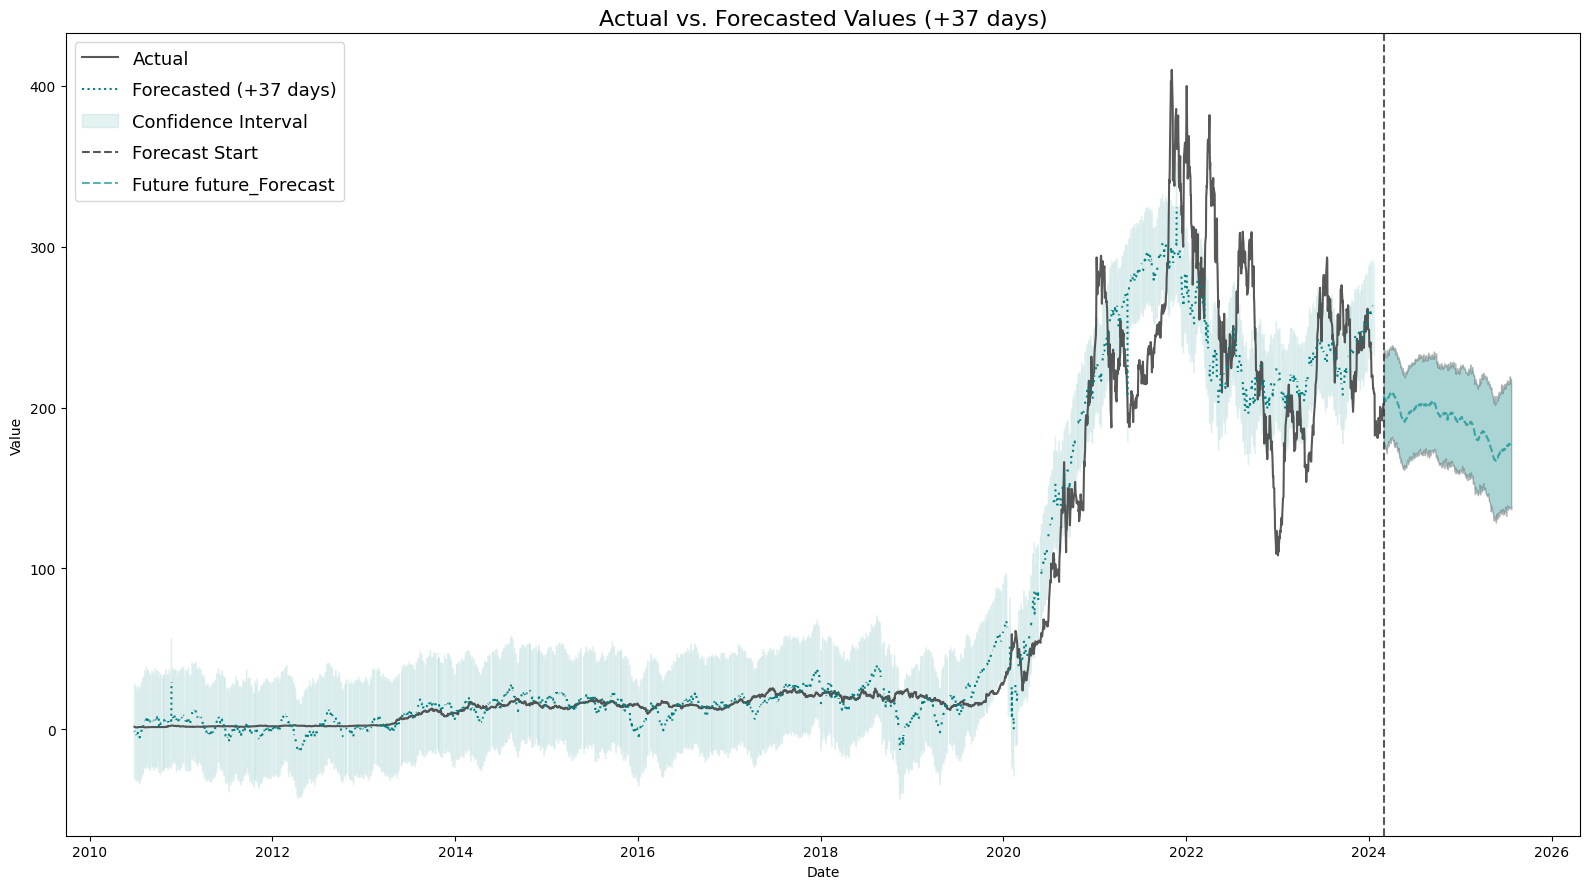

In [28]:
# Define the forecast horizon
forecast_horizon_days = 37

# Create a DataFrame for plotting
plot_df = pd.DataFrame()

# Copy the dates and actual values from the historical data
plot_df['ds'] = stock_1_df['ds']
plot_df['Actual'] = stock_1_df['y']

# Initialize an empty list to store the forecasted values for the horizon
forecasted_values = []

# Loop over the historical dates
for idx, row in plot_df.iterrows():
    forecast_date = row['ds'] + pd.Timedelta(days=forecast_horizon_days)
    # Find the forecasted value for the horizon date
    forecasted_value = historical_forecast.loc[historical_forecast['ds'] == forecast_date, 'yhat'].values
    # Append the forecasted value to the list, or NaN if not found
    forecasted_values.append(forecasted_value[0] if len(forecasted_value) > 0 else None)

# Add the forecasted values to the plotting DataFrame
plot_df['Forecasted'] = forecasted_values

# Plotting
plt.figure(figsize=(16, 9))

# Assuming 'yhat_lower' and 'yhat_upper' are available in 'historical_forecast'
forecasted_values_lower = []
forecasted_values_upper = []

for idx, row in plot_df.iterrows():
    forecast_date = row['ds'] + pd.Timedelta(days=forecast_horizon_days)
    forecasted_value_lower = historical_forecast.loc[historical_forecast['ds'] == forecast_date, 'yhat_lower'].values
    forecasted_value_upper = historical_forecast.loc[historical_forecast['ds'] == forecast_date, 'yhat_upper'].values
    forecasted_values_lower.append(forecasted_value_lower[0] if len(forecasted_value_lower) > 0 else None)
    forecasted_values_upper.append(forecasted_value_upper[0] if len(forecasted_value_upper) > 0 else None)

plot_df['Forecasted_Lower'] = forecasted_values_lower
plot_df['Forecasted_Upper'] = forecasted_values_upper



# Plotting the confidence interval for past predictions

plt.plot(plot_df['ds'], plot_df['Actual'], label='Actual', color='.2', alpha=.82)
plt.plot(plot_df['ds'], plot_df['Forecasted'], label=f'Forecasted (+{forecast_horizon_days} days)', color='teal', linestyle='dotted')
plt.fill_between(plot_df['ds'], plot_df['Forecasted_Lower'], plot_df['Forecasted_Upper'], color='teal', alpha=0.1, label='Confidence Interval')


plt.axvline(plot_df['ds'].iloc[-1] + pd.Timedelta(days=1), color='.2', alpha=.82, linestyle='--', label='Forecast Start')

# Plot future forecast with confidence intervals
plt.plot(future_forecast['ds'], future_forecast['yhat'], label='Future future_Forecast', color='darkcyan', alpha=0.65, linestyle='--')
plt.fill_between(future_forecast['ds'], future_forecast['yhat_lower'], future_forecast['yhat_upper'], color='teal', edgecolor='0.2', alpha=0.33)

# Formatting
plt.title(f'Actual vs. Forecasted Values (+{forecast_horizon_days} days)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='upper left', fontsize = 13, labelspacing = .75)

plt.tight_layout()
plt.show()


### Stock 1 Volatility

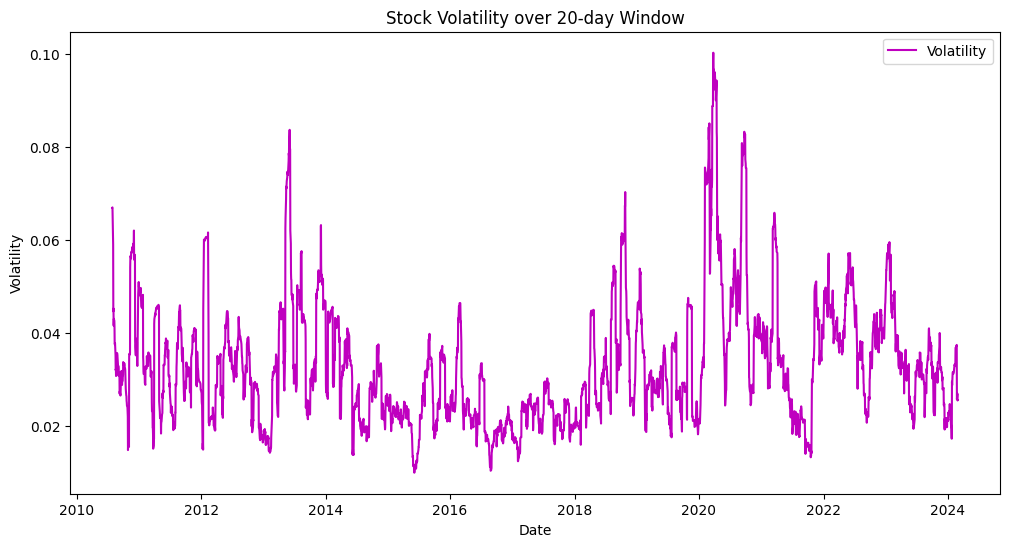

In [29]:
def plot_stock_volatility(stock_data, window=20):
    # Parameters:
    # - stock_data (DataFrame): DataFrame containing stock price data, with columns including 'ds' for dates and 'y' for closing prices.
    # - window (int): The moving window size for calculating volatility.

    # Returns:
    # - A matplotlib plot showing the stock's volatility over time.

    # Calculate daily returns as percentage change in closing price
    stock_1_df['daily_returns'] = stock_1_df['y'].pct_change()

    # Calculate rolling standard deviation of daily returns over the specified window to represent volatility
    stock_1_df['volatility'] = stock_1_df['daily_returns'].rolling(window=window).std()

    # Plotting the volatility
    plt.figure(figsize=(12, 6))
    plt.plot(stock_1_df['ds'], stock_1_df['volatility'], label='Volatility', color='m')
    plt.title(f'Stock Volatility over {window}-day Window')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.show()

# Assuming `stock_1_df` is your DataFrame with 'ds' as date column and 'y' as closing price
plot_stock_volatility(stock_1_df)


In [30]:
# Calculate daily percentage change. `pct_change()` computes the percentage change from the previous row by default.
stock_1_df['Daily Change (%)'] = stock_1_df['Close'].pct_change() * 100

# Sort the DataFrame based on the 'Daily Change (%)' in descending order to get the days with the largest moves first
largest_moves = stock_1_df.sort_values(by='Daily Change (%)', ascending=False)

# Display the top 5 days with the largest moves
print(largest_moves[['ds', 'Daily Change (%)']].head(5))

                   ds  Daily Change (%)
Date                                   
2013-05-09 2013-05-09         24.395076
2020-02-03 2020-02-03         19.894859
2021-03-09 2021-03-09         19.641208
2010-11-10 2010-11-10         19.204203
2020-03-19 2020-03-19         18.387684


<ipython-input-31-8ec48b62f44a>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




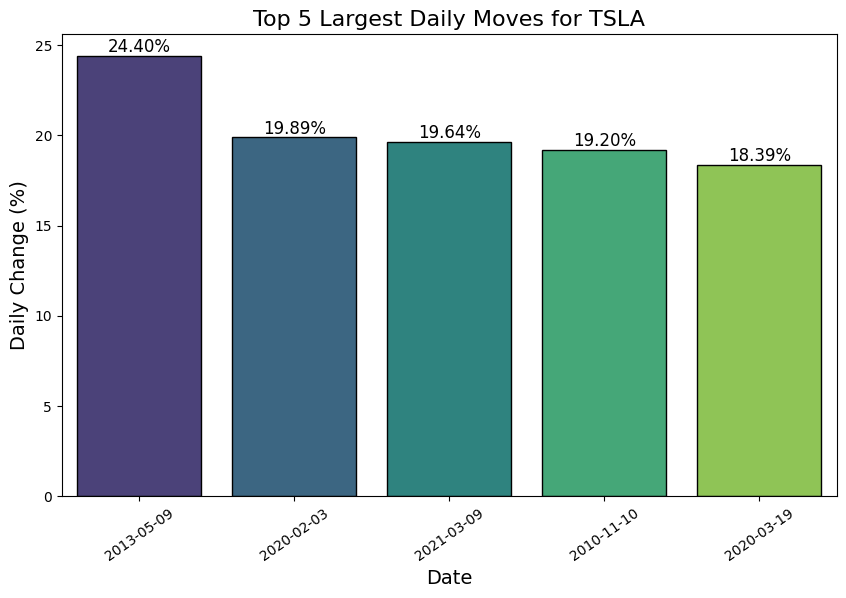

In [31]:
top_5_moves = largest_moves.head(5)

# Create a bar plot
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
ax = sns.barplot(x='Date', y='Daily Change (%)', data=top_5_moves, palette='viridis', edgecolor='black')

# Add titles and labels
plt.title(f'Top 5 Largest Daily Moves for {DEFAULT_SYMBOL.upper()}', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Daily Change (%)', fontsize=14)
plt.xticks(rotation=35)  # Rotate the x-axis labels for better readability

# Overlay the values on the bars
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2.,  # x position
            p.get_height(),  # y position
            '{:.2f}%'.format(p.get_height()),  # text
            fontsize=12,
            ha='center',  # horizontal alignment
            va='bottom')  # vertical alignment

# Display
plt.show()


### Stock 1 MACD

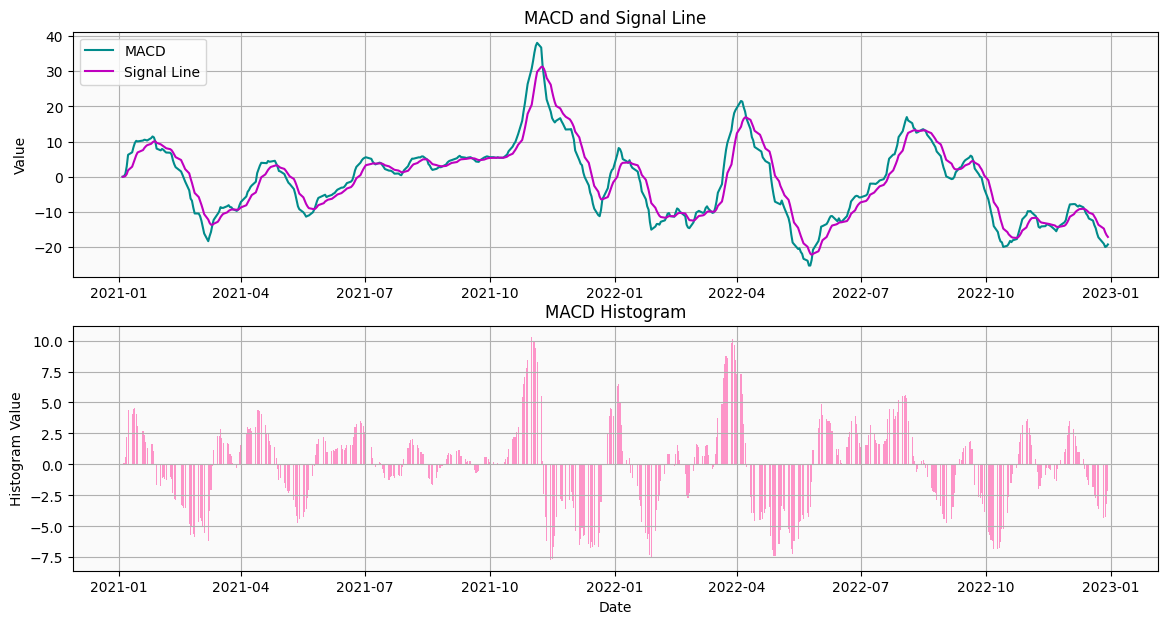

In [32]:

def plot_macd(stock_data, start_date=None, end_date=None, date_column='ds', close_column='y'):
    """
    Calculates and plots the MACD line, Signal line, and MACD Histogram for stock data within a specified date range.

    Parameters:
    - stock_data (DataFrame): DataFrame containing stock price data, with columns for dates and closing prices.
    - start_date (str): The start date for the analysis in 'YYYY-MM-DD' format. If None, analysis starts from the first available date.
    - end_date (str): The end date for the analysis in 'YYYY-MM-DD' format. If None, analysis ends at the last available date.
    - date_column (str): The name of the column in `stock_data` that contains date information.
    - close_column (str): The name of the column in `stock_data` that contains closing price information.

    Returns:
    - A matplotlib plot showing the MACD line, Signal line, and MACD Histogram within the specified date range.
    """
    # Filter the data for the specified date range
    if start_date:
        stock_data = stock_data[stock_data[date_column] >= start_date]
    if end_date:
        stock_data = stock_data[stock_data[date_column] <= end_date]

    # Ensure the DataFrame is sorted by date
    #stock_data = stock_data.sort_values(by=date_column)

    # Calculate the MACD and Signal Line indicators
    short_ema = stock_data[close_column].ewm(span=12, adjust=False).mean()
    long_ema = stock_data[close_column].ewm(span=26, adjust=False).mean()
    stock_data['MACD'] = short_ema - long_ema
    stock_data['Signal_Line'] = stock_data['MACD'].ewm(span=9, adjust=False).mean()
    stock_data['MACD_Histogram'] = stock_data['MACD'] - stock_data['Signal_Line']

    # Plotting
    plt.figure(figsize=(14, 7))
    ax1 = plt.subplot(2, 1, 1)
    ax1.set_facecolor('0.98')
    ax1.plot(stock_data[date_column], stock_data['MACD'], label='MACD', color='darkcyan', linewidth=1.5)
    ax1.plot(stock_data[date_column], stock_data['Signal_Line'], label='Signal Line', color='m', linewidth=1.5)
    ax1.legend(loc='upper left')
    ax1.set_title('MACD and Signal Line')
    ax1.set_ylabel('Value')
    ax1.grid(True)

    ax2 = plt.subplot(2, 1, 2, sharex=ax1)
    ax2.set_facecolor('0.98')
    ax2.bar(stock_data[date_column], stock_data['MACD_Histogram'], label='Histogram', color='hotpink', alpha=0.7)
    ax2.grid(True)
    ax2.set_title('MACD Histogram')
    ax2.set_ylabel('Histogram Value')
    ax2.set_xlabel('Date')

    plt.show()

# Usage example with 'stock_1_df' DataFrame and specifying a date range
plot_macd(stock_1_df, start_date='2021-01-01', end_date='2022-12-31')


### Stock 1 Bollinger Bands

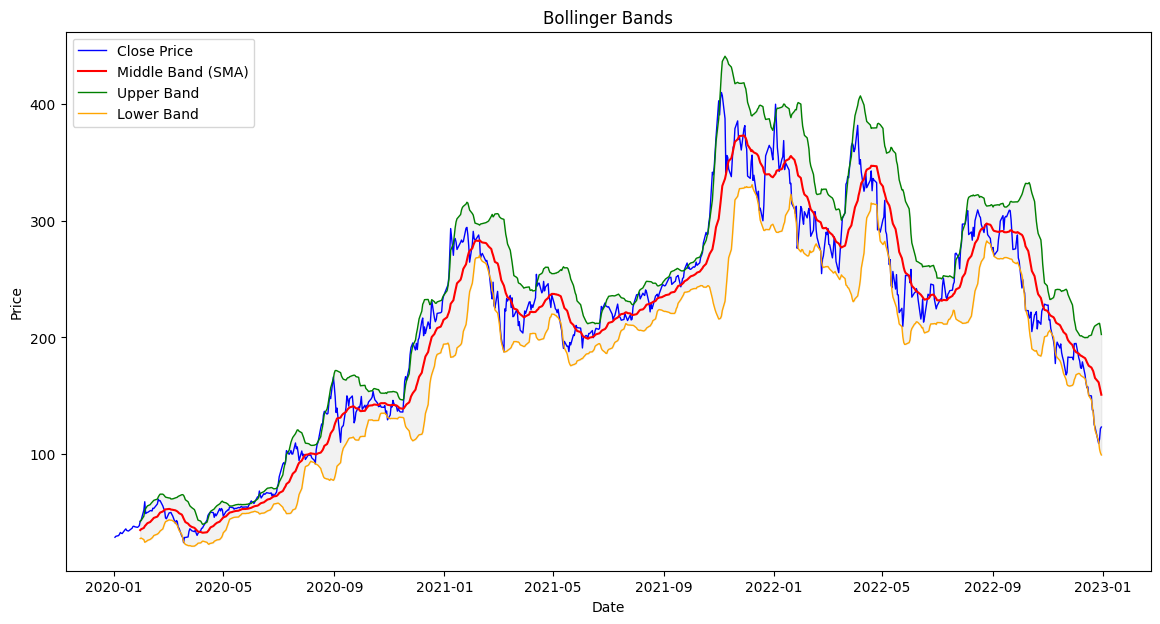

In [33]:
def plot_bollinger_bands(stock_data, start_date=None, end_date=None, window=20, width=2, date_column='ds', close_column='y'):
    """
    Calculates and plots Bollinger Bands for stock data within a specified date range.

    Parameters:
    - stock_data (DataFrame): DataFrame containing stock price data, with columns for dates and closing prices.
    - start_date (str): The start date for the analysis in 'YYYY-MM-DD' format. If None, analysis starts from the first available date.
    - end_date (str): The end date for the analysis in 'YYYY-MM-DD' format. If None, analysis ends at the last available date.
    - window (int): The moving window size for calculating the simple moving average (SMA) and standard deviation. Default is 20.
    - width (int): The number of standard deviations away from the SMA the upper and lower bands should be. Default is 2.
    - date_column (str): The name of the column in `stock_data` that contains date information.
    - close_column (str): The name of the column in `stock_data` that contains closing price information.

    Returns:
    - A matplotlib plot showing the Bollinger Bands and the closing price within the specified date range.
    """
    # Filter the data for the specified date range
    if start_date:
        stock_data = stock_data[stock_data[date_column] >= start_date]
    if end_date:
        stock_data = stock_data[stock_data[date_column] <= end_date]

    # Ensure the DataFrame is sorted by date
    # hd
    # stock_data = stock_data.sort_values(by=index)

    # Calculate the middle band (simple moving average)
    stock_data['Middle_Band'] = stock_data[close_column].rolling(window=window).mean()

    # Calculate the standard deviation
    std_dev = stock_data[close_column].rolling(window=window).std()

    # Calculate the upper and lower bands
    stock_data['Upper_Band'] = stock_data['Middle_Band'] + (std_dev * width)
    stock_data['Lower_Band'] = stock_data['Middle_Band'] - (std_dev * width)

    # Plotting
    plt.figure(figsize=(14, 7))
    plt.plot(stock_data[date_column], stock_data[close_column], label='Close Price', color='blue', linewidth=1)
    plt.plot(stock_data[date_column], stock_data['Middle_Band'], label='Middle Band (SMA)', color='red', linewidth=1.5)
    plt.plot(stock_data[date_column], stock_data['Upper_Band'], label='Upper Band', color='green', linewidth=1)
    plt.plot(stock_data[date_column], stock_data['Lower_Band'], label='Lower Band', color='orange', linewidth=1)

    plt.fill_between(stock_data[date_column], stock_data['Lower_Band'], stock_data['Upper_Band'], color='grey', alpha=0.1)

    plt.title('Bollinger Bands')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(loc='upper left')
    plt.show()

# Usage example with 'stock_1_df' DataFrame and specifying a date range
plot_bollinger_bands(stock_1_df, start_date='2020-01-01', end_date='2022-12-31')


In [34]:
stock_1_df.head()

Open      High       Low     Close         y     Volume  \
Date                                                                      
2010-06-29  1.266667  1.666667  1.169333  1.592667  1.592667  281494500   
2010-06-30  1.719333  2.028000  1.553333  1.588667  1.588667  257806500   
2010-07-01  1.666667  1.728000  1.351333  1.464000  1.464000  123282000   
2010-07-02  1.533333  1.540000  1.247333  1.280000  1.280000   77097000   
2010-07-06  1.333333  1.333333  1.055333  1.074000  1.074000  103003500   

            market_index day_of_week month  year       MA50      MA200  \
Date                                                                     
2010-06-29   1041.239990     Tuesday  June  2010  71.614495  69.374796   
2010-06-30   1030.709961   Wednesday  June  2010  71.614495  69.374796   
2010-07-01   1027.369995    Thursday  July  2010  71.614495  69.374796   
2010-07-02   1022.580017      Friday  July  2010  71.614495  69.374796   
2010-07-06   1028.060059     Tuesday  July  2010  71.614495  69.374796   

            market_index_scaled         ds  daily_returns  volatility  \
Date                                                                    
2010-06-29          2082.479980 2010-06-29            NaN         NaN   
2010-06-30          2061.419922 2010-06-30      -0.002511         NaN   
2010-07-01          2054.739990 2010-07-01      -0.078473         NaN   
2010-07-02          2045.160034 2010-07-02      -0.125683         NaN   
2010-07-06          2056.120117 2010-07-06      -0.160937         NaN   

            Daily Change (%)  
Date                          
2010-06-29               NaN  
2010-06-30         -0.251148  
2010-07-01         -7.847274  
2010-07-02        -12.568307  
2010-07-06        -16.093748

In [35]:
stock_2_df.head()

Open       High    Low      Close  Adj Close    Volume  \
Date                                                                      
2010-06-29  29.150000  29.150000  28.42  28.629999  20.820194  22817400   
2010-06-30  28.530001  28.860001  27.99  28.070000  20.412949  20940900   
2010-07-01  28.410000  28.500000  27.49  27.920000  20.303867  27119600   
2010-07-02  28.010000  28.010000  27.58  27.760000  20.187513  15404500   
2010-07-06  27.990000  28.129999  27.10  27.340000  19.882080  18300200   

                 Date  
Date                   
2010-06-29 2010-06-29  
2010-06-30 2010-06-30  
2010-07-01 2010-07-01  
2010-07-02 2010-07-02  
2010-07-06 2010-07-06

In [36]:
stock_1_df_copy

Open        High         Low       Close           y  \
Date                                                                     
2010-06-29    1.266667    1.666667    1.169333    1.592667    1.592667   
2010-06-30    1.719333    2.028000    1.553333    1.588667    1.588667   
2010-07-01    1.666667    1.728000    1.351333    1.464000    1.464000   
2010-07-02    1.533333    1.540000    1.247333    1.280000    1.280000   
2010-07-06    1.333333    1.333333    1.055333    1.074000    1.074000   
...                ...         ...         ...         ...         ...   
2024-02-22  194.000000  198.320007  191.360001  197.410004  197.410004   
2024-02-23  195.309998  197.570007  191.500000  191.970001  191.970001   
2024-02-26  192.289993  201.779999  192.000000  199.399994  199.399994   
2024-02-27  204.039993  205.600006  198.259995  199.729996  199.729996   
2024-02-28  200.419998  205.300003  198.460007  202.039993  202.039993   

               Volume  market_index day_of_week     month  year        MA50  \
Date                                                                          
2010-06-29  281494500   1041.239990     Tuesday      June  2010   71.614495   
2010-06-30  257806500   1030.709961   Wednesday      June  2010   71.614495   
2010-07-01  123282000   1027.369995    Thursday      July  2010   71.614495   
2010-07-02   77097000   1022.580017      Friday      July  2010   71.614495   
2010-07-06  103003500   1028.060059     Tuesday      July  2010   71.614495   
...               ...           ...         ...       ...   ...         ...   
2024-02-22   92739500   5087.029785    Thursday  February  2024  218.067200   
2024-02-23   78670300   5088.799805      Friday  February  2024  217.111800   
2024-02-26  111747100   5069.529785      Monday  February  2024  216.359600   
2024-02-27  108645400   5078.180176     Tuesday  February  2024  215.568400   
2024-02-28   98769230   5069.759766   Wednesday  February  2024  214.588200   

                 MA200  market_index_scaled         ds  daily_returns  \
Date                                                                    
2010-06-29   69.374796          2082.479980 2010-06-29            NaN   
2010-06-30   69.374796          2061.419922 2010-06-30      -0.002511   
2010-07-01   69.374796          2054.739990 2010-07-01      -0.078473   
2010-07-02   69.374796          2045.160034 2010-07-02      -0.125683   
2010-07-06   69.374796          2056.120117 2010-07-06      -0.160937   
...                ...                  ...        ...            ...   
2024-02-22  233.882800         10174.059570 2024-02-22       0.013554   
2024-02-23  233.983700         10177.599609 2024-02-23      -0.027557   
2024-02-26  234.134950         10139.059570 2024-02-26       0.038704   
2024-02-27  234.290900         10156.360352 2024-02-27       0.001655   
2024-02-28  234.440700         10139.519531 2024-02-28       0.011566   

            volatility  Daily Change (%)  
Date                                      
2010-06-29         NaN               NaN  
2010-06-30         NaN         -0.251148  
2010-07-01         NaN         -7.847274  
2010-07-02         NaN        -12.568307  
2010-07-06         NaN        -16.093748  
...                ...               ...  
2024-02-22    0.037373          1.355445  
2024-02-23    0.025658         -2.755687  
2024-02-26    0.026886          3.870393  
2024-02-27    0.025410          0.165497  
2024-02-28    0.025490          1.156560  

[3440 rows x 17 columns]

## Stock 1 and 2 DataFrame Merging

In [37]:
# Reset the index for stock_1_df_copy, if 'Date' is part of the index
if 'Date' in stock_1_df_copy.index.names:
    # Check if 'Date' column already exists to avoid duplication
    if 'Date' not in stock_1_df_copy.columns:
        stock_1_df_copy = stock_1_df_copy.reset_index()
    else:
        stock_1_df_copy = stock_1_df_copy.reset_index(drop=True)

# Assuming stock_2_df_copy is defined and needs similar treatment
# Reset the index for stock_2_df_copy, if 'Date' is part of the index
if 'Date' in stock_2_df_copy.index.names:
    # Check if 'Date' column already exists to avoid duplication
    if 'Date' not in stock_2_df_copy.columns:
        stock_2_df_copy = stock_2_df_copy.reset_index()
    else:
        stock_2_df_copy = stock_2_df_copy.reset_index(drop=True)

# Merge the DataFrames on the 'Date' column
# Ensure DEFAULT_SYMBOL and symbol_2 are defined and replace them with actual symbol names
merged_df = pd.merge(stock_1_df_copy, stock_2_df_copy, on='Date', suffixes=(f'_{DEFAULT_SYMBOL}', f'_{symbol_2}'))


In [38]:
merged_df

Date   Open_TSLA   High_TSLA    Low_TSLA  Close_TSLA           y  \
0    2010-06-29    1.266667    1.666667    1.169333    1.592667    1.592667   
1    2010-06-30    1.719333    2.028000    1.553333    1.588667    1.588667   
2    2010-07-01    1.666667    1.728000    1.351333    1.464000    1.464000   
3    2010-07-02    1.533333    1.540000    1.247333    1.280000    1.280000   
4    2010-07-06    1.333333    1.333333    1.055333    1.074000    1.074000   
...         ...         ...         ...         ...         ...         ...   
3435 2024-02-22  194.000000  198.320007  191.360001  197.410004  197.410004   
3436 2024-02-23  195.309998  197.570007  191.500000  191.970001  191.970001   
3437 2024-02-26  192.289993  201.779999  192.000000  199.399994  199.399994   
3438 2024-02-27  204.039993  205.600006  198.259995  199.729996  199.729996   
3439 2024-02-28  200.419998  205.300003  198.460007  202.039993  202.039993   

      Volume_TSLA  market_index day_of_week     month  ...         ds  \
0       281494500   1041.239990     Tuesday      June  ... 2010-06-29   
1       257806500   1030.709961   Wednesday      June  ... 2010-06-30   
2       123282000   1027.369995    Thursday      July  ... 2010-07-01   
3        77097000   1022.580017      Friday      July  ... 2010-07-02   
4       103003500   1028.060059     Tuesday      July  ... 2010-07-06   
...           ...           ...         ...       ...  ...        ...   
3435     92739500   5087.029785    Thursday  February  ... 2024-02-22   
3436     78670300   5088.799805      Friday  February  ... 2024-02-23   
3437    111747100   5069.529785      Monday  February  ... 2024-02-26   
3438    108645400   5078.180176     Tuesday  February  ... 2024-02-27   
3439     98769230   5069.759766   Wednesday  February  ... 2024-02-28   

      daily_returns  volatility  Daily Change (%)     Open_HD     High_HD  \
0               NaN         NaN               NaN   29.150000   29.150000   
1         -0.002511         NaN         -0.251148   28.530001   28.860001   
2         -0.078473         NaN         -7.847274   28.410000   28.500000   
3         -0.125683         NaN        -12.568307   28.010000   28.010000   
4         -0.160937         NaN        -16.093748   27.990000   28.129999   
...             ...         ...               ...         ...         ...   
3435       0.013554    0.037373          1.355445  367.440002  372.959991   
3436      -0.027557    0.025658         -2.755687  372.079987  374.250000   
3437       0.038704    0.026886          3.870393  373.510010  374.880005   
3438       0.001655    0.025410          0.165497  372.660004  375.799988   
3439       0.011566    0.025490          1.156560  375.559998  379.839996   

          Low_HD    Close_HD   Adj Close  Volume_HD  
0      28.420000   28.629999   20.820194   22817400  
1      27.990000   28.070000   20.412949   20940900  
2      27.490000   27.920000   20.303867   27119600  
3      27.580000   27.760000   20.187513   15404500  
4      27.100000   27.340000   19.882080   18300200  
...          ...         ...         ...        ...  
3435  367.149994  371.339996  371.339996    3387500  
3436  370.250000  371.959991  371.959991    3398200  
3437  370.720001  371.600006  371.600006    2461000  
3438  370.609985  375.559998  375.559998    2802900  
3439  375.059998  377.609985  377.609985    2261701  

[3440 rows x 24 columns]

### Merged DF Comparisons

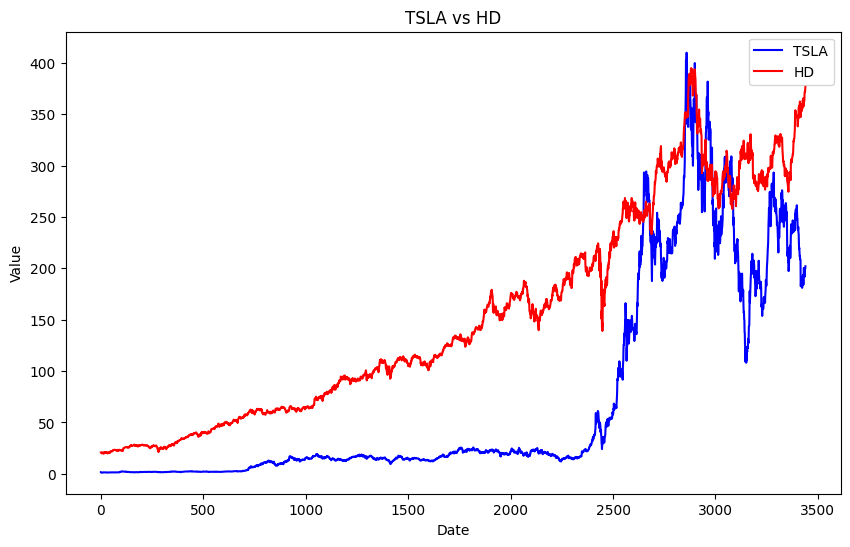

'\nYou NEEEED to add dates to the X\n'

In [39]:
# Plotting
plt.figure(figsize=(10, 6))  # Optional: Adjusts the size of the plot

# Plotting Feature1
plt.plot(merged_df.index, merged_df[f'y'], label=f'{DEFAULT_SYMBOL.upper()}', color='blue')

# Plotting Feature2
plt.plot(merged_df.index, merged_df[f'Adj Close'], label=f'{symbol_2.upper()}', color='red')

# Adding titles and labels
plt.title(f'{DEFAULT_SYMBOL.upper()} vs {symbol_2.upper()}')
plt.xlabel('Date')
plt.ylabel('Value')

# Adding a legend
plt.legend()

# Display the plot
plt.show()




"""
You NEEEED to add dates to the X
"""

In [40]:
start_date = '2011-07-01'

## Correlation Coefficient Calculation

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


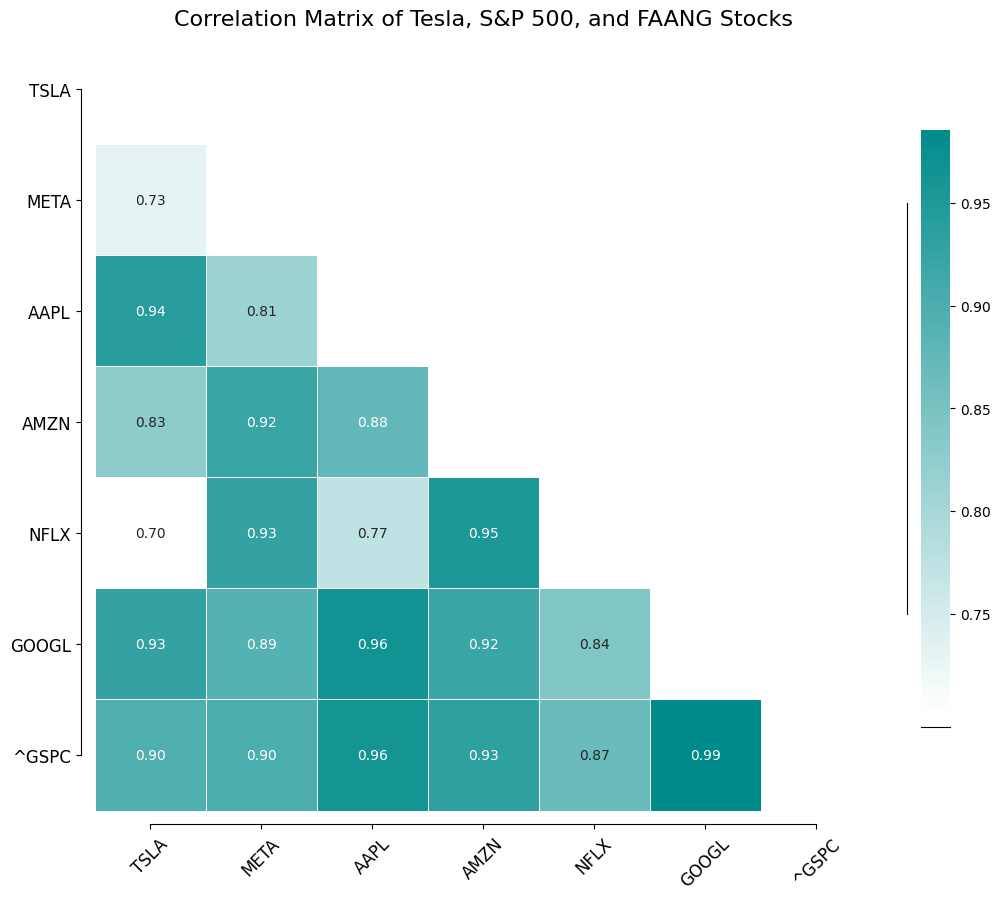

In [41]:
from matplotlib.colors import LinearSegmentedColormap

def fetch_adjusted_close_prices(start_date):
    symbols = ['TSLA', 'META', 'AAPL', 'AMZN', 'NFLX', 'GOOGL', '^GSPC']
    adj_close_df = pd.DataFrame()
    for symbol in symbols:
        data = yf.download(symbol, start=start_date)['Adj Close']
        adj_close_df[symbol] = data
    adj_close_df.fillna(method='ffill', inplace=True)
    adj_close_df.dropna(inplace=True)
    return adj_close_df

adj_close_df = fetch_adjusted_close_prices(start_date)

corr = adj_close_df.corr()

# Exclude the diagonal for vmin and vmax calculation
mask_upper_triangle = np.triu(np.ones_like(corr, dtype=bool))
corr_no_diag = corr.mask(mask_upper_triangle)

vmin, vmax = corr_no_diag.min().min(), corr_no_diag.max().max()

f, ax = plt.subplots(figsize=(11, 9))

# Custom colormap from white to yellow to orange to red
colors = ["white", "darkcyan"]
n_bins = 100  # Increase this number for a smoother transition
cmap = LinearSegmentedColormap.from_list(name="custom", colors=colors, N=n_bins)

sns.heatmap(corr, mask=mask_upper_triangle, cmap=cmap, vmin=vmin, vmax=vmax,
            annot=True, fmt=".2f",
            square=True, linewidths=.5, cbar_kws={"shrink": .75})

sns.despine(offset=10, trim=True)

plt.title('Correlation Matrix of Tesla, S&P 500, and FAANG Stocks', fontsize=16)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12, rotation=0)

plt.tight_layout()
plt.show()




In [42]:
adj_close_df

TSLA        META        AAPL        AMZN        NFLX  \
Date                                                                     
2012-05-18    1.837333   38.189480   16.036402   10.692500    9.994286   
2012-05-21    1.918000   33.993931   16.970688   10.905500   10.248571   
2012-05-22    2.053333   30.967144   16.840370   10.766500    9.672857   
2012-05-23    2.068000   31.966084   17.251282   10.864000   10.272857   
2012-05-24    2.018667   32.994991   17.092850   10.762000   10.038571   
...                ...         ...         ...         ...         ...   
2024-02-22  197.410004  486.130005  184.369995  174.580002  588.469971   
2024-02-23  191.970001  484.029999  182.520004  174.990005  583.559998   
2024-02-26  199.399994  481.739990  181.160004  174.729996  587.650024   
2024-02-27  199.729996  487.049988  182.630005  173.539993  601.669983   
2024-02-28  202.039993  484.019989  181.419998  173.160004  596.479980   

                 GOOGL        ^GSPC  
Date                                 
2012-05-18   15.025025  1295.219971  
2012-05-21   15.368118  1315.989990  
2012-05-22   15.035035  1316.630005  
2012-05-23   15.251752  1318.859985  
2012-05-24   15.106607  1320.680054  
...                ...          ...  
2024-02-22  144.089996  5087.029785  
2024-02-23  143.960007  5088.799805  
2024-02-26  137.570007  5069.529785  
2024-02-27  138.880005  5078.180176  
2024-02-28  136.380005  5069.759766  

[2963 rows x 7 columns]

In [43]:
# Calculate daily returns for TSLA and the S&P 500
stock_1_df['TSLA_daily_returns'] = stock_1_df['Close'].pct_change()
stock_1_df['SP500_daily_returns'] = stock_1_df['market_index'].pct_change()

# Aggregate these daily returns to get annual returns
# We'll group by the 'year' column and then apply a lambda function to calculate the product of (1 + daily returns)
TSLA_annual_returns = stock_1_df.groupby('year')['TSLA_daily_returns'].apply(lambda x: (1 + x).prod() - 1)
SP500_annual_returns = stock_1_df.groupby('year')['SP500_daily_returns'].apply(lambda x: (1 + x).prod() - 1)

# Combine both annual returns into a single DataFrame for comparison
annual_returns_comparison = pd.DataFrame({
    'TSLA': TSLA_annual_returns,
    'SP500': SP500_annual_returns
})

# Determine years where TSLA outperformed the S&P 500
outperforming_years = annual_returns_comparison[annual_returns_comparison['TSLA'] > annual_returns_comparison['SP500']].index.tolist()

print("Years where TSLA outperformed the S&P 500:", outperforming_years)


Years where TSLA outperformed the S&P 500: [2011, 2012, 2013, 2014, 2015, 2017, 2018, 2020, 2021, 2023]


In [44]:
import plotly.graph_objs as go
from plotly.offline import iplot

# Extracting years, TSLA returns, and S&P 500 returns from the DataFrame
years = annual_returns_comparison.index
tsla_returns = annual_returns_comparison['TSLA']
sp500_returns = annual_returns_comparison['SP500']

# Identifying outperforming years
outperforming_years = annual_returns_comparison[annual_returns_comparison['TSLA'] > annual_returns_comparison['SP500']].index

# Line plot for TSLA and S&P 500 returns
tsla_line = go.Scatter(x=years, y=tsla_returns, mode='lines+markers', name='TSLA',
                       line=dict(color='darkcyan'), marker=dict(size=8),
                       hoverinfo='text', text=[f'TSLA: {round(ret*100, 2)}%' for ret in tsla_returns])

sp500_line = go.Scatter(x=years, y=sp500_returns, mode='lines+markers', name='S&P 500',
                        line=dict(color='darkmagenta'), marker=dict(size=8),
                        hoverinfo='text', text=[f'S&P 500: {round(ret*100, 2)}%' for ret in sp500_returns])

# Highlight outperforming years with larger stars
highlight = go.Scatter(x=outperforming_years, y=tsla_returns.loc[outperforming_years],
                       mode='markers', name='TSLA Outperformed',
                       marker=dict(color='magenta', size=30, symbol='star'),
                       hoverinfo='text',
                       text=[f'Year: {year}<br>TSLA: {round(tsla_returns.loc[year]*100, 2)}%' for year in outperforming_years])

# Layout customization
layout = go.Layout(title='Annual Returns: TSLA vs S&P 500',
                   xaxis=dict(title='Year'),
                   yaxis=dict(title='Annual Return', tickformat=".0%"),
                   legend=dict(x=0.1, y=1.1, orientation='h'),
                   plot_bgcolor='white',
                   hovermode='closest')

# Initialize figure
fig = go.Figure(data=[tsla_line, sp500_line, highlight], layout=layout)

# Add flags for outperforming years
for year in outperforming_years:
    fig.add_annotation(x=year, y=tsla_returns.loc[year], text=str(year), showarrow=True,
                       arrowhead=1, arrowsize=1, arrowwidth=2, arrowcolor='magenta',
                       font=dict(color='black', size=12),
                       bgcolor='white', bordercolor='darkcyan',
                       borderwidth=2, borderpad=4, ax=0, ay=-40)

# Render the figure
iplot(fig)


In [45]:
# import plotly.graph_objs as go
# from plotly.offline import iplot

# # Highlighting function
# def highlight_bar(year):
#     if year in outperforming_years:
#         return 'limegreen'  # Red color with some transparency
#     return 'red'  # Default blue color with some transparency

# # Data for plotting
# data = [
#     go.Bar(name='TSLA',
#            x=annual_returns_comparison.index,
#            y=annual_returns_comparison['TSLA'],
#            marker_color=[highlight_bar(year) for year in annual_returns_comparison.index]),  # Use highlight function for color
#     go.Bar(name='S&P 500',
#            x=annual_returns_comparison.index,
#            y=annual_returns_comparison['SP500'],
#            marker_color='darkgrey')  # Green color for S&P 500 bars
# ]

# # Customize the layout
# layout = go.Layout(
#     title='Annual Returns Comparison: TSLA vs S&P 500',
#     xaxis=dict(title='Year'),
#     yaxis=dict(title='Annual Return'),
#     barmode='group'
# )

# # Create the figure
# fig = go.Figure(data=data, layout=layout)

# # Render the figure
# iplot(fig)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

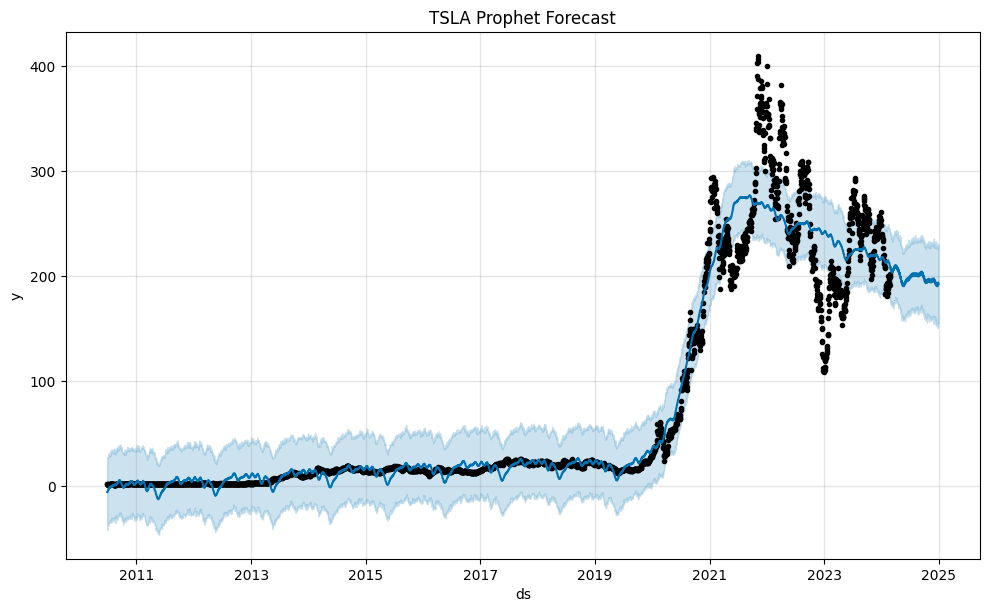

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/y7o3svf8.json


TSLA ROI: -7.05%


DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/ouputwui.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40619', 'data', 'file=/tmp/tmpex2sxn0p/y7o3svf8.json', 'init=/tmp/tmpex2sxn0p/ouputwui.json', 'output', 'file=/tmp/tmpex2sxn0p/prophet_modelt5y6510i/prophet_model-20240229002723.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:27:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:27:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


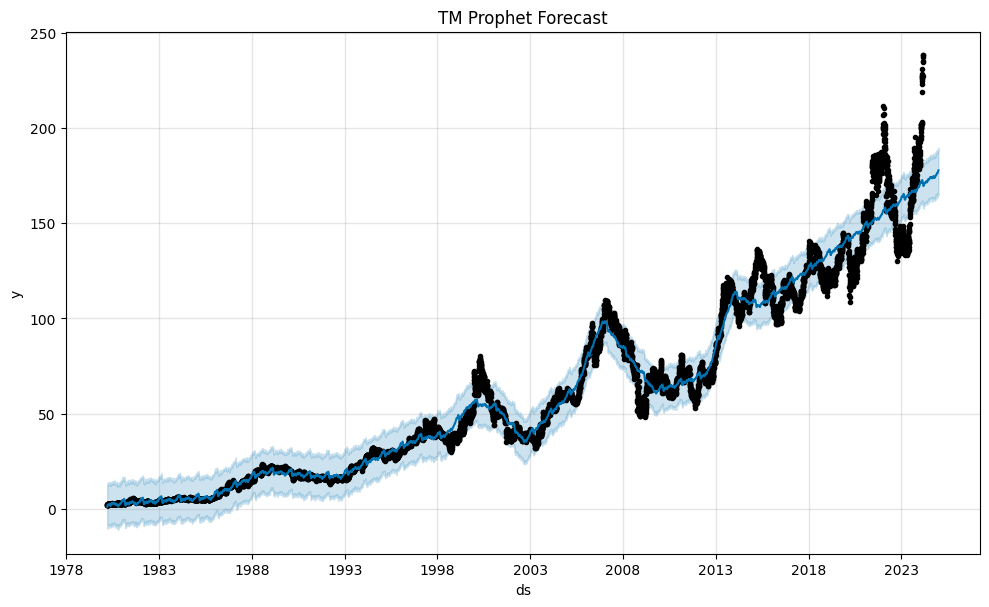

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/mw12n4bg.json


TM ROI: 4.03%


DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/io44vvhb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77746', 'data', 'file=/tmp/tmpex2sxn0p/mw12n4bg.json', 'init=/tmp/tmpex2sxn0p/io44vvhb.json', 'output', 'file=/tmp/tmpex2sxn0p/prophet_modelb9lqttj9/prophet_model-20240229002736.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:27:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:27:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


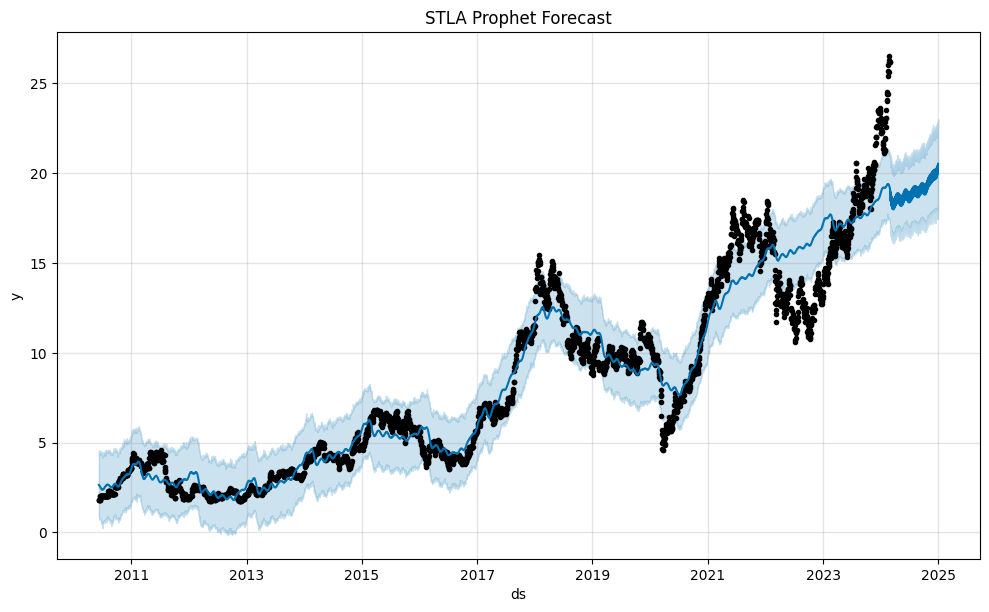

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/c8hu0s3p.json


STLA ROI: 7.22%


DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/5thfn2dg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87585', 'data', 'file=/tmp/tmpex2sxn0p/c8hu0s3p.json', 'init=/tmp/tmpex2sxn0p/5thfn2dg.json', 'output', 'file=/tmp/tmpex2sxn0p/prophet_modelzn1tqkey/prophet_model-20240229002740.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:27:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:27:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


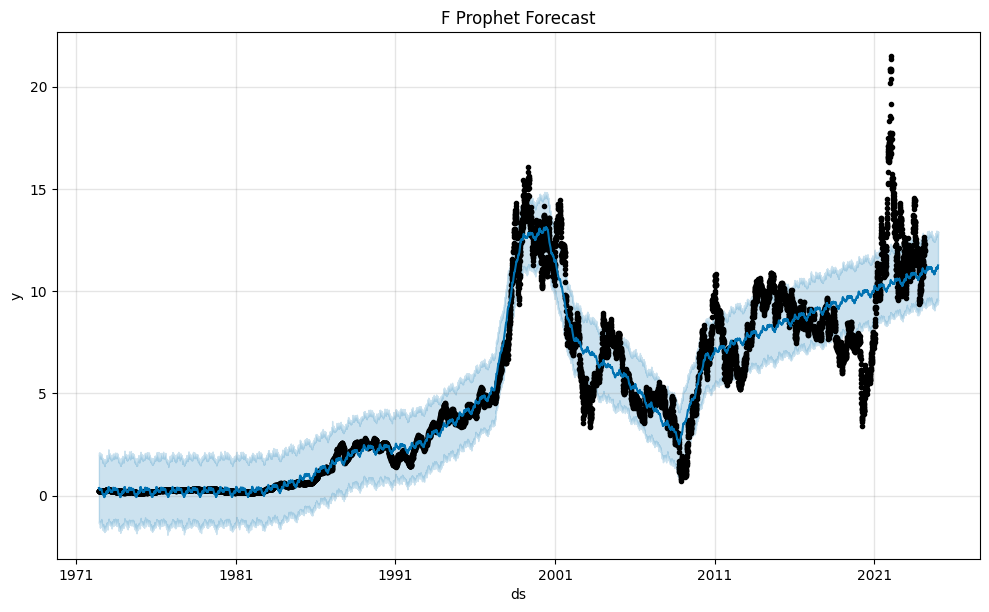

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/if0ecb1h.json


F ROI: 2.91%


DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/f29fvfq3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73104', 'data', 'file=/tmp/tmpex2sxn0p/if0ecb1h.json', 'init=/tmp/tmpex2sxn0p/f29fvfq3.json', 'output', 'file=/tmp/tmpex2sxn0p/prophet_modelqt9rg5it/prophet_model-20240229002756.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:27:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:27:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


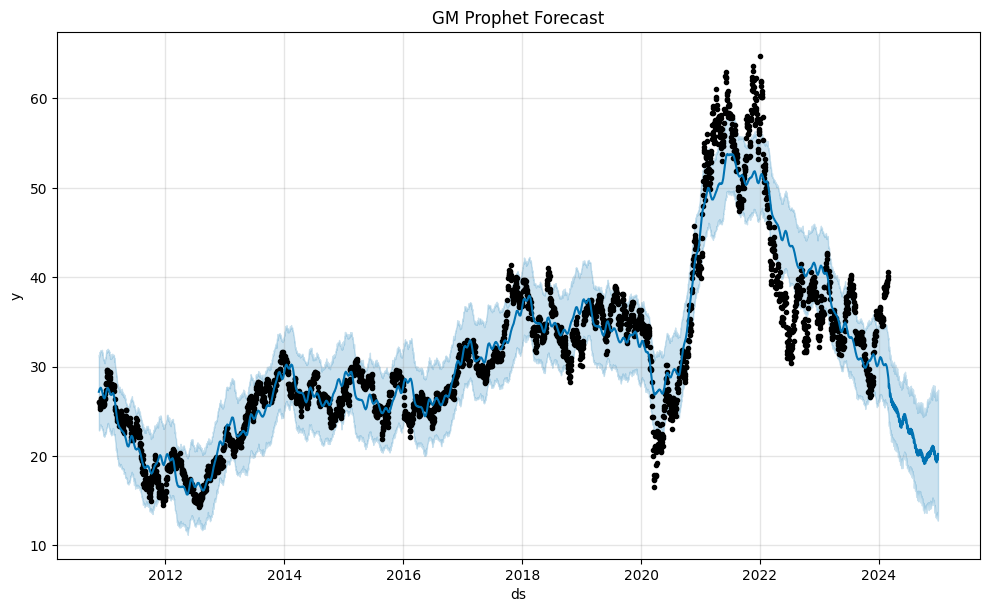

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/0bkcf2in.json


GM ROI: -29.38%


DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/6fchmcc_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92245', 'data', 'file=/tmp/tmpex2sxn0p/0bkcf2in.json', 'init=/tmp/tmpex2sxn0p/6fchmcc_.json', 'output', 'file=/tmp/tmpex2sxn0p/prophet_modeln0qzn0ev/prophet_model-20240229002800.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:28:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:28:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


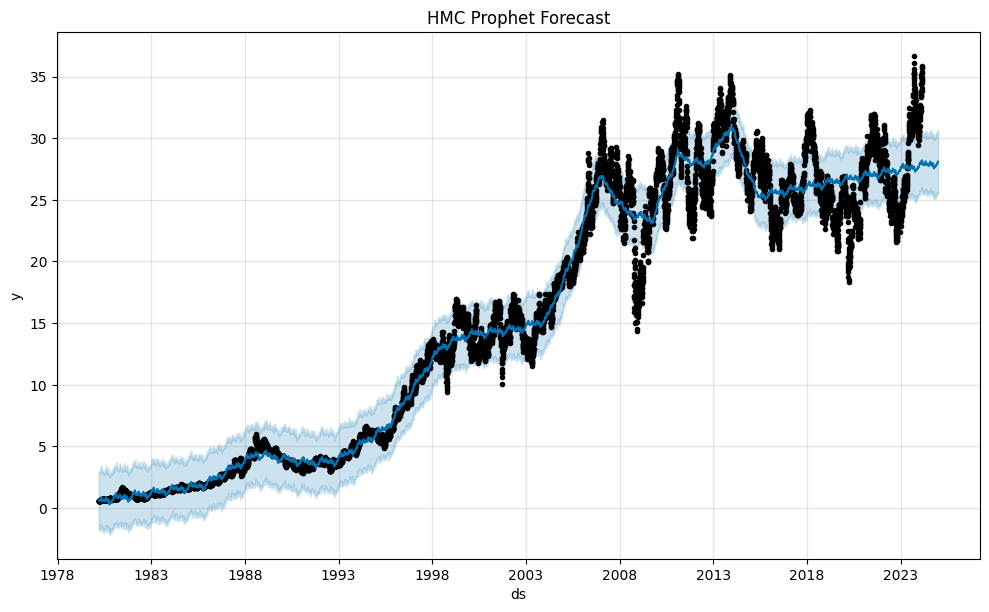

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/j6vn16ph.json


HMC ROI: 0.21%


DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/0641d46l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35061', 'data', 'file=/tmp/tmpex2sxn0p/j6vn16ph.json', 'init=/tmp/tmpex2sxn0p/0641d46l.json', 'output', 'file=/tmp/tmpex2sxn0p/prophet_modelabrmfhlw/prophet_model-20240229002812.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:28:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:28:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


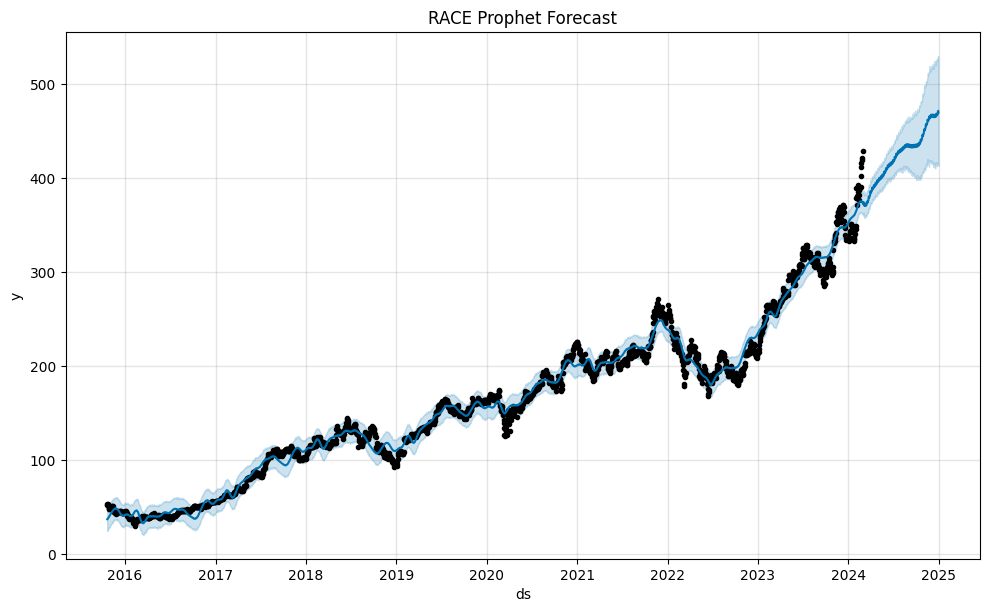

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/04tdrud6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/p22jc4pi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44123', 'data', 'file=/tmp/tmpex2sxn0p/04tdrud6.json', 'init=/tmp/tmpex2sxn0p/p22jc4pi.json', 'output', 'file=/tmp/tmpex2sxn0p/prophet_model7nxauqcn/prophet_model-20240229002814.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:28:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


RACE ROI: 25.95%


00:28:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


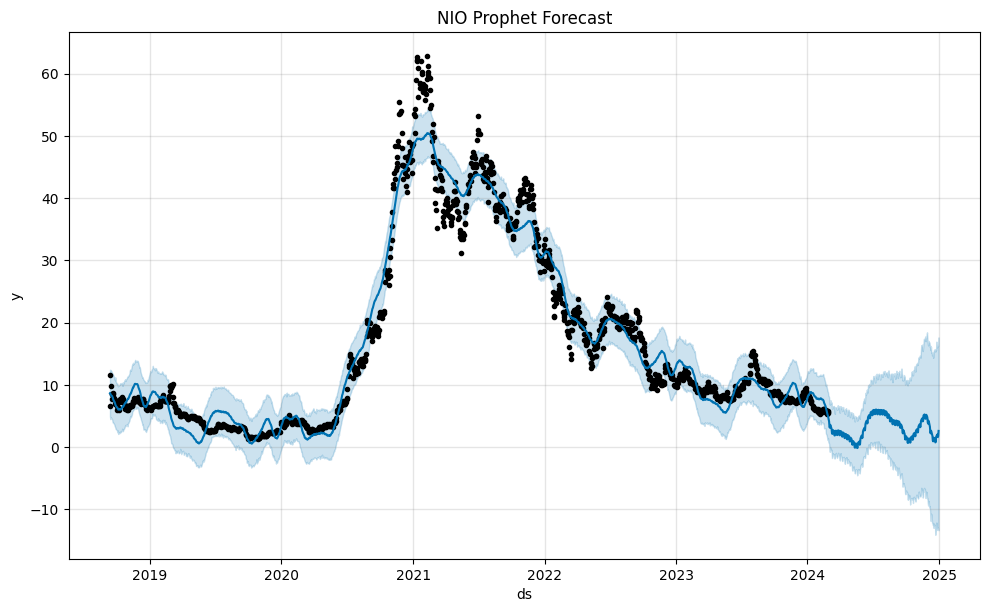

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/lothh53w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/bhr1aiic.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23743', 'data', 'file=/tmp/tmpex2sxn0p/lothh53w.json', 'init=/tmp/tmpex2sxn0p/bhr1aiic.json', 'output', 'file=/tmp/tmpex2sxn0p/prophet_model1q8qsmt4/prophet_model-20240229002816.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:28:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


NIO ROI: -41.65%


00:28:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


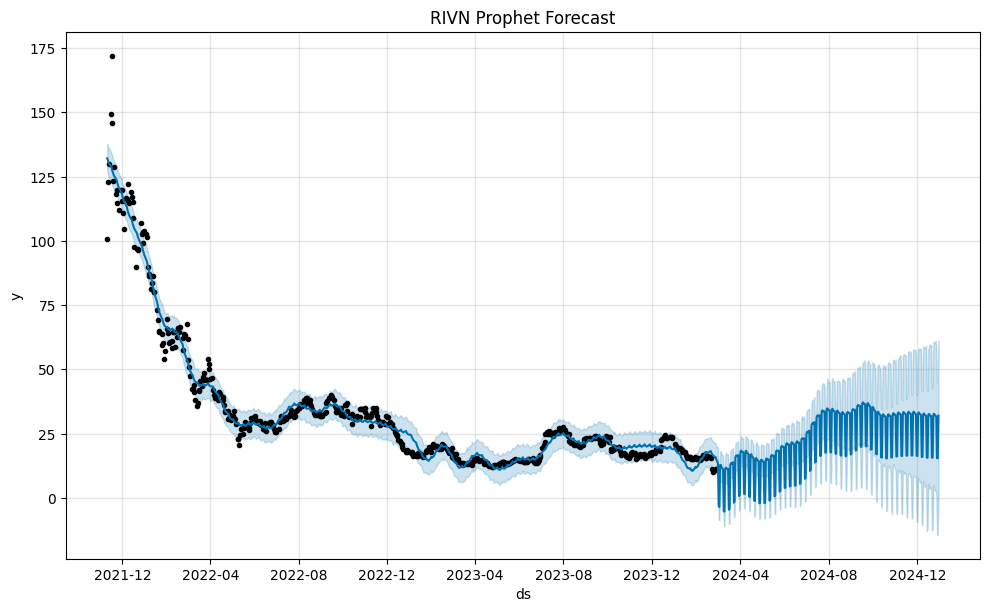

RIVN ROI: 125.62%


In [46]:
import pandas as pd
import yfinance as yf
from prophet import Prophet
import datetime
import matplotlib.pyplot as plt

# Constants
TOP_10_NYSE_AUTO = ['TSLA', 'TM', 'STLA', 'F', 'GM', 'HMC', 'RACE', 'NIO', 'RIVN']

# Function to calculate days until end of year
def return_eoy():
    today = datetime.date.today()
    end_of_year = datetime.date(today.year, 12, 31)
    delta = end_of_year - today
    return delta.days

# Function to fetch and clean stock data
def fetch_and_prepare_stock_data(stock_symbol):
    try:
        df = yf.download(stock_symbol, period="max")
        df.fillna(df.mean(), inplace=True)
        df.reset_index(inplace=True)
        df.rename(columns={'Date': 'ds', 'Adj Close': 'y'}, inplace=True)
        df['Ticker'] = stock_symbol  # Add a column for the ticker symbol
        return df
    except Exception as e:
        print(f"Error downloading {stock_symbol}: {e}")
        return None

# Function to create and fit a Prophet model, then forecast
def forecast_stock(stock_dataframe, days_until_eoy):
    prophet_model = Prophet()
    prophet_model.fit(stock_dataframe)
    future = prophet_model.make_future_dataframe(periods=days_until_eoy)
    forecast = prophet_model.predict(future)
    prophet_model.plot(forecast)
    plt.title(f"{stock_dataframe['Ticker'].iloc[0].upper()} Prophet Forecast")
    plt.show()
    return forecast

# Main script logic
days_until_eoy = return_eoy()  # Call once and reuse

# Fetch, clean, and prepare data for all stocks
stock_dataframes = [fetch_and_prepare_stock_data(stock) for stock in TOP_10_NYSE_AUTO if fetch_and_prepare_stock_data(stock) is not None]

# Iterate over prepared DataFrames to generate and plot forecasts, then calculate ROI
for stock_df in stock_dataframes:
    forecast_df = forecast_stock(stock_df, days_until_eoy)
    forecasted_timeframe = forecast_df.iloc[-days_until_eoy:, :]
    roi = (forecasted_timeframe.iloc[-1]["yhat"] - forecasted_timeframe.iloc[0]["yhat"]) / forecasted_timeframe.iloc[0]["yhat"]
    print(f"{stock_df['Ticker'].iloc[0].upper()} ROI: {round(roi * 100, 2)}%")


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/1oz82jqa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/j2ik3ed2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51511', 'data', 'file=/tmp/tmpex2sxn0p/1oz82jqa.json', 'init=/tmp/tmpex2sxn0p/j2ik3ed2.json', 'output', 'file=/tmp/tmpex2sxn0p/prophet_modelpc_mamji/prophet_model-20240229002817.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:28:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:28:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


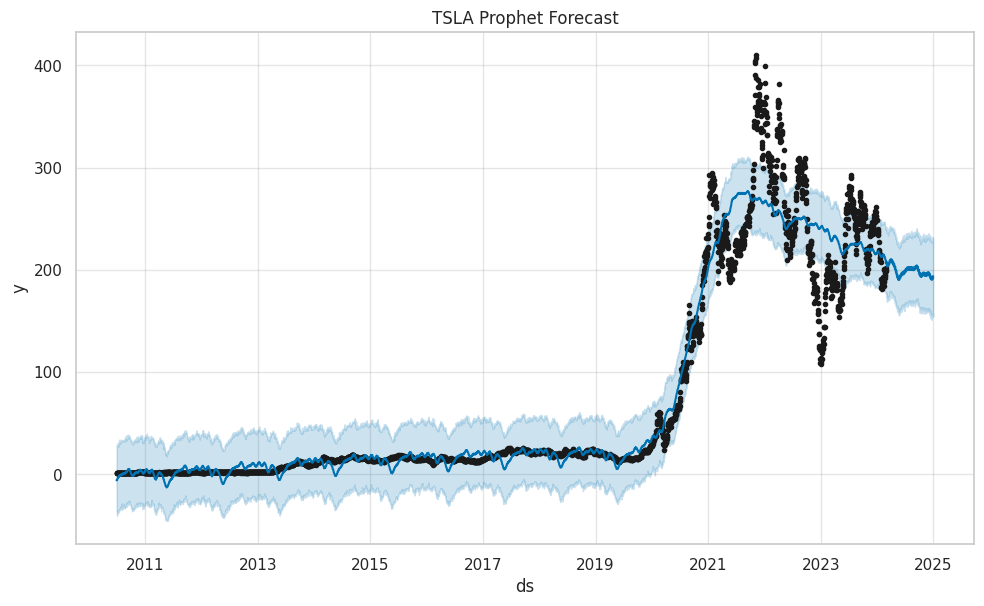

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/l6f2rw91.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/9sx1fnw1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87913', 'data', 'file=/tmp/tmpex2sxn0p/l6f2rw91.json', 'init=/tmp/tmpex2sxn0p/9sx1fnw1.json', 'output', 'file=/tmp/tmpex2sxn0p/prophet_modelsbx1jfx3/prophet_model-20240229002821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:28:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:28:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


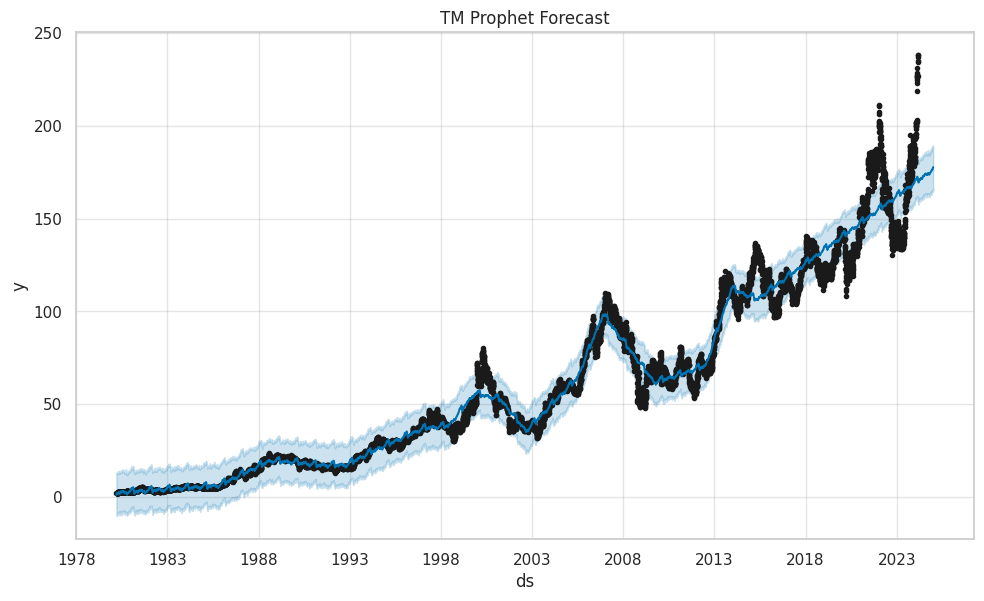

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/z37tlg9k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/o9o3p5e1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14772', 'data', 'file=/tmp/tmpex2sxn0p/z37tlg9k.json', 'init=/tmp/tmpex2sxn0p/o9o3p5e1.json', 'output', 'file=/tmp/tmpex2sxn0p/prophet_modeleuzvayx1/prophet_model-20240229002833.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:28:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:28:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


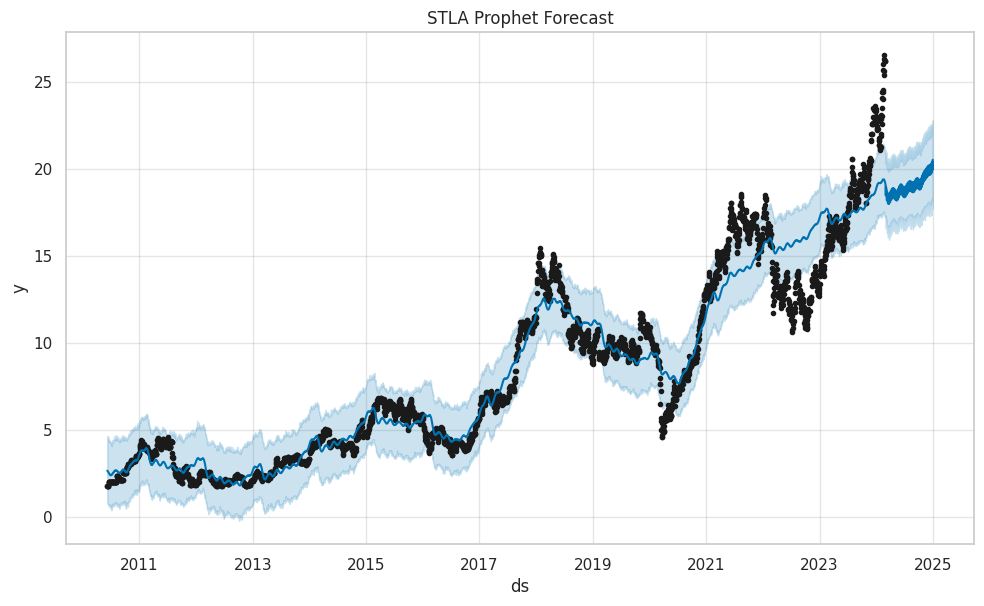

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/rm2xicns.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/sxcyf6au.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60698', 'data', 'file=/tmp/tmpex2sxn0p/rm2xicns.json', 'init=/tmp/tmpex2sxn0p/sxcyf6au.json', 'output', 'file=/tmp/tmpex2sxn0p/prophet_modelo8y372ud/prophet_model-20240229002837.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:28:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:28:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


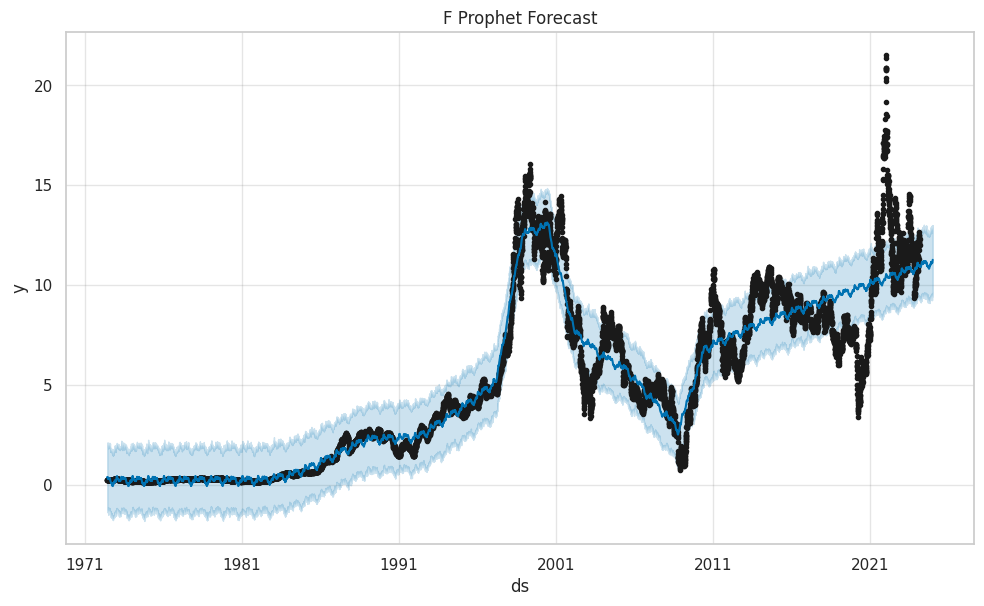

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/epeb1kk5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/y39vianw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67921', 'data', 'file=/tmp/tmpex2sxn0p/epeb1kk5.json', 'init=/tmp/tmpex2sxn0p/y39vianw.json', 'output', 'file=/tmp/tmpex2sxn0p/prophet_modeln_vnygnc/prophet_model-20240229002852.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:28:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:28:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


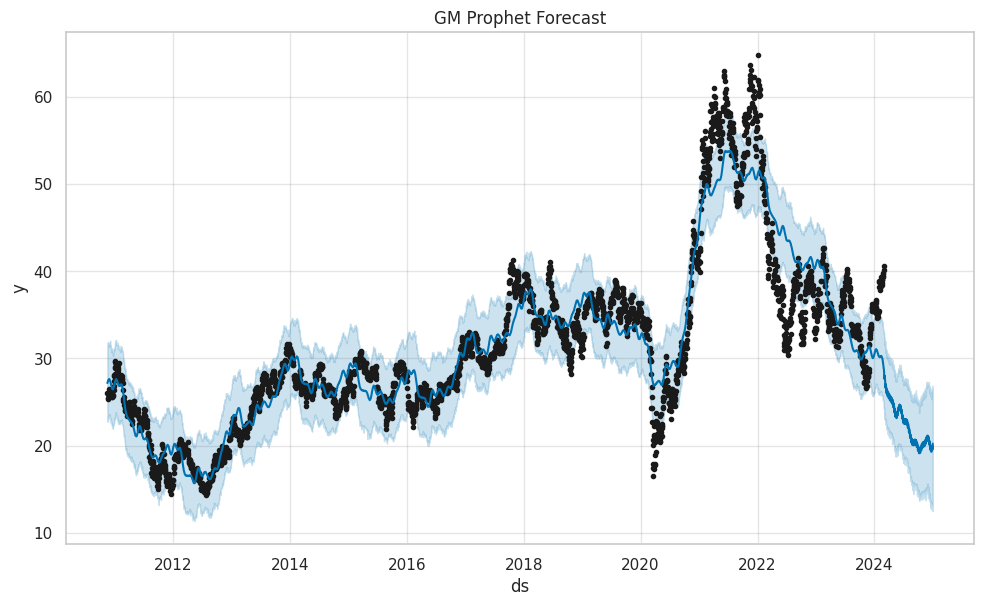

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/f1ne2clc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/h4sqjkww.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95289', 'data', 'file=/tmp/tmpex2sxn0p/f1ne2clc.json', 'init=/tmp/tmpex2sxn0p/h4sqjkww.json', 'output', 'file=/tmp/tmpex2sxn0p/prophet_modelaiztezln/prophet_model-20240229002856.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:28:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:29:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


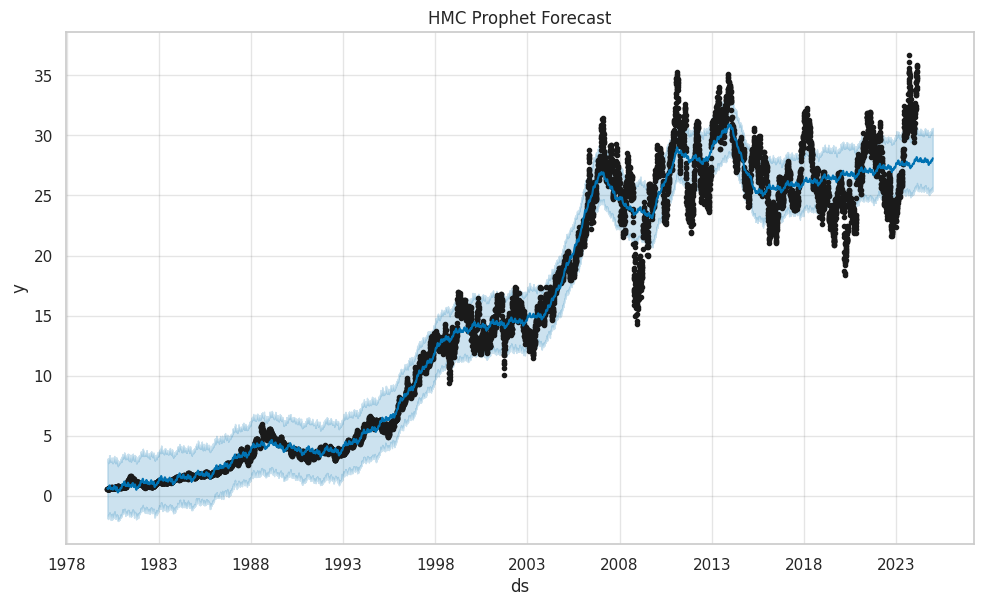

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/y6mcvhku.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/o8wefv03.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85056', 'data', 'file=/tmp/tmpex2sxn0p/y6mcvhku.json', 'init=/tmp/tmpex2sxn0p/o8wefv03.json', 'output', 'file=/tmp/tmpex2sxn0p/prophet_modelagjyktrl/prophet_model-20240229002908.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:29:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:29:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


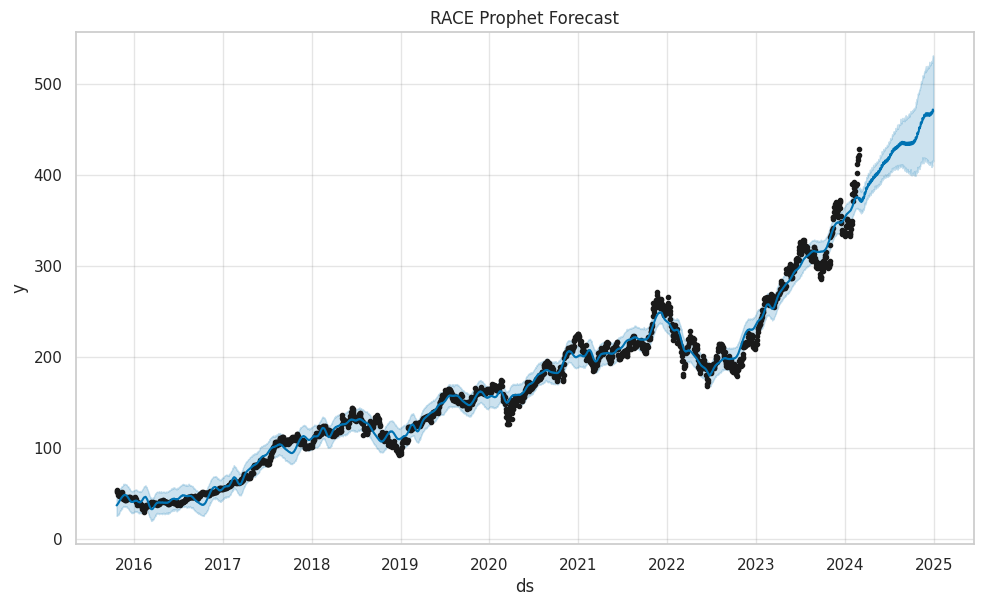

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/c0vdtk2o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/9hyrjidz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15717', 'data', 'file=/tmp/tmpex2sxn0p/c0vdtk2o.json', 'init=/tmp/tmpex2sxn0p/9hyrjidz.json', 'output', 'file=/tmp/tmpex2sxn0p/prophet_modelahbt59oh/prophet_model-20240229002912.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:29:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:29:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


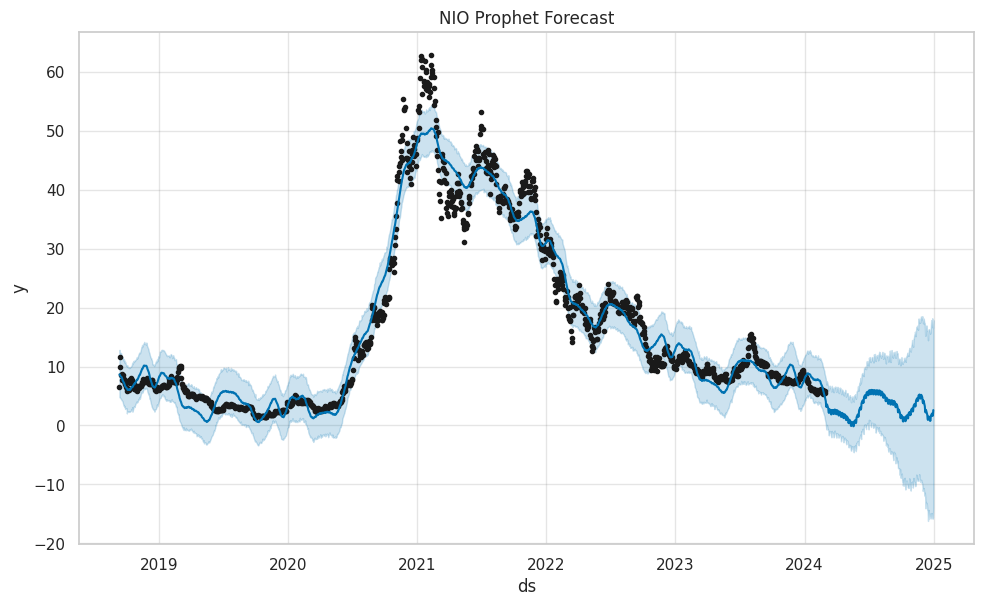

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/kn_915wd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2sxn0p/sicvmbow.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96530', 'data', 'file=/tmp/tmpex2sxn0p/kn_915wd.json', 'init=/tmp/tmpex2sxn0p/sicvmbow.json', 'output', 'file=/tmp/tmpex2sxn0p/prophet_modelhh6cjyt3/prophet_model-20240229002914.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:29:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:29:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


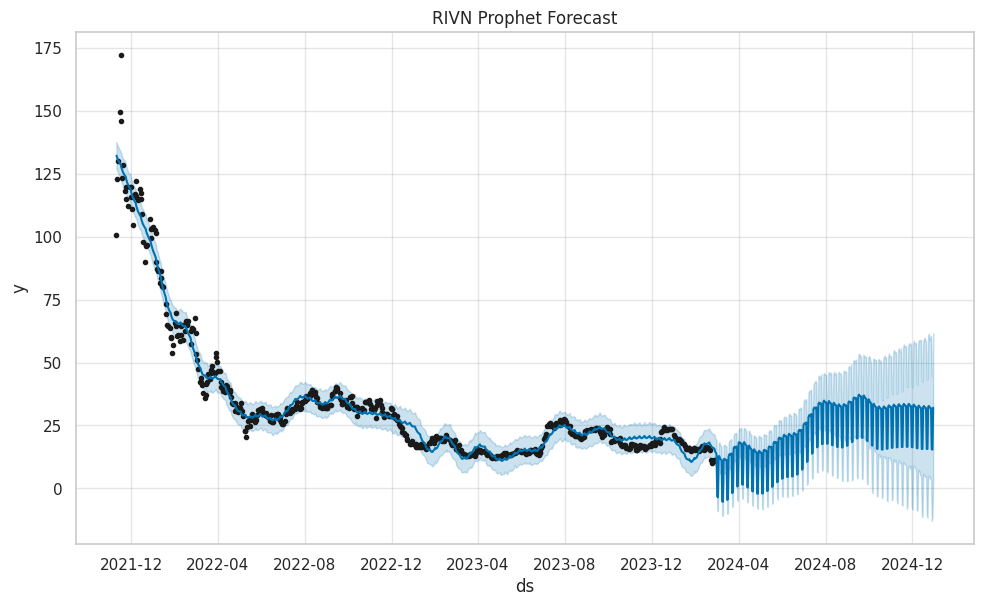

<ipython-input-47-76c539de0b86>:38: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



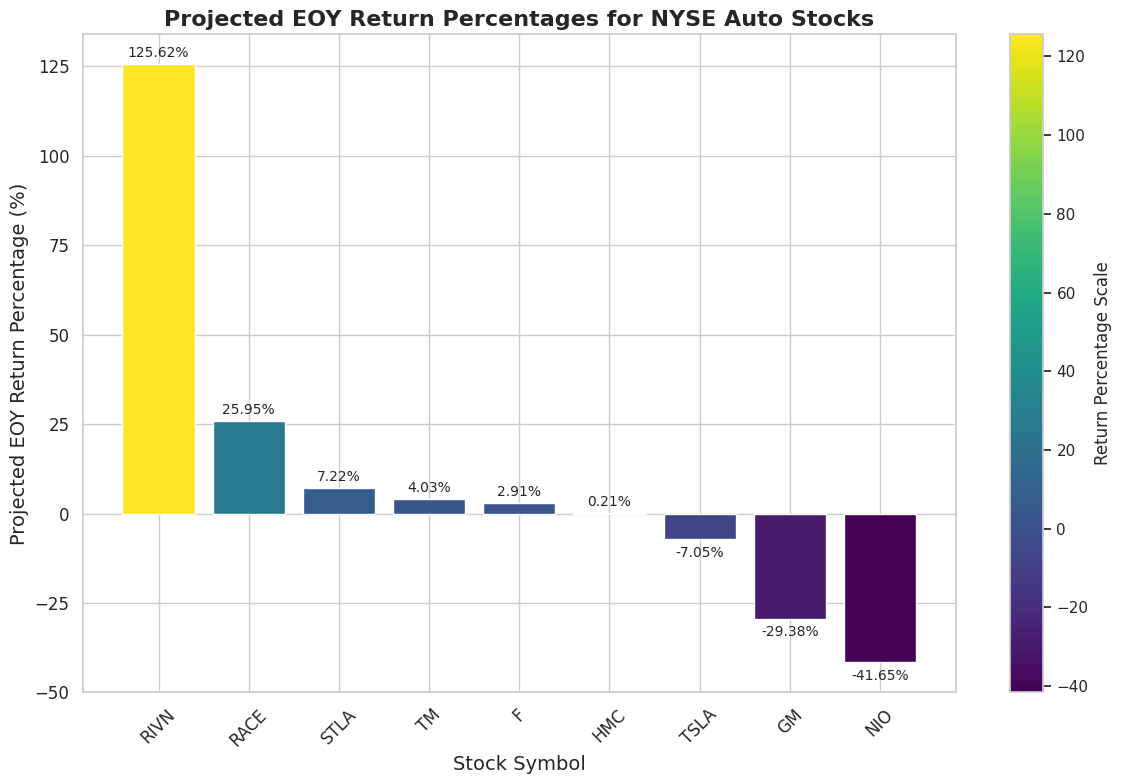

In [47]:
# Set the Seaborn theme for better aesthetics
sns.set_theme(style="whitegrid")

# Initialize a dictionary to hold the EOY return percentages for each stock
eoy_return_percentages = {}

# Iterate over the stock dataframes to calculate the EOY return percentage
for stock_df in stock_dataframes:
    # Use the previously generated forecasts
    forecast_df = forecast_stock(stock_df, days_until_eoy)

    # Extract the first and last forecasted values in the forecasted timeframe
    start_of_forecast = forecast_df.iloc[-days_until_eoy]["yhat"]
    end_of_forecast = forecast_df.iloc[-1]["yhat"]

    # Calculate the return percentage
    return_percentage = ((end_of_forecast - start_of_forecast) / start_of_forecast) * 100

    # Store the return percentage in the dictionary with the stock ticker as the key
    eoy_return_percentages[stock_df['Ticker'].iloc[0]] = return_percentage

# Sort the dictionary by return percentage for a more organized plot
sorted_symbols = sorted(eoy_return_percentages, key=eoy_return_percentages.get, reverse=True)
sorted_values = [eoy_return_percentages[symbol] for symbol in sorted_symbols]

# Plotting the EOY return percentages for all stocks
plt.figure(figsize=(12, 8))

# Enhanced bar plot with color mapping based on return percentage
colors = plt.cm.viridis((np.array(sorted_values) - min(sorted_values)) / (max(sorted_values) - min(sorted_values)))
bar_plot = plt.bar(sorted_symbols, sorted_values, color=colors)

plt.title('Projected EOY Return Percentages for NYSE Auto Stocks', fontsize=16, fontweight='bold')
plt.xlabel('Stock Symbol', fontsize=14)
plt.ylabel('Projected EOY Return Percentage (%)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)  # Rotate stock symbols for better readability
plt.yticks(fontsize=12)
plt.colorbar(plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(min(sorted_values), max(sorted_values))),
             orientation='vertical', label='Return Percentage Scale')

# Add value labels on top of each bar
for bar in bar_plot:
    height = bar.get_height()
    # Determine position based on positive or negative value
    offset = -15 if height < 0 else 3  # Adjust offset for negative values to be below the bar
    plt.annotate(f'{height:.2f}%',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, offset),  # Offset position based on value sign
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=10, fontweight='medium')

plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()